# **Time Series Data Forecasting**

## **1. Data Preprocessing and Exploration**

### **a. Importing Important Libraries**

In [107]:
import os
import warnings 
import pprint
from typing import Dict
import itertools

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import AutoReg
import pmdarima as pm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import sys 

sys.path.append('../')

### **b. Prepration of Environment**

In [2]:
def path_to_work(end_directory: str = 'notebooks') -> None:
   
    curr_dir = os.path.dirname(os.path.realpath("__file__"))

    if curr_dir.endswith(end_directory):
        os.chdir('..')
        return f'Changed directory to: {curr_dir}'
    else:
        return f'Current working directory: {curr_dir}'



In [3]:
def plot_box_plot(df: pd.core.frame.DataFrame, dataset_name: str, xlim=None) -> None:
    if xlim is not None:
        plt.xlim(*xlim)

    plt.title(f"Horizontal Boxplot {dataset_name}")
    plt.ylabel('Dependent Variables')
    plt.xlabel('Measurement x')
    ax = sns.boxplot(data=df, orient='h', palette='Set2', notch=False)
    plt.show()

In [4]:
def save_image(img: 'matplotlib', name: str, path: str = 'reports/images/') -> None:
    img.get_figure().savefig(f"{path}/{name}.png")
    print(f"{name} saved at {path}.")


In [5]:
def save_dataframe(df: pd.core.frame.DataFrame, path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf=path, sep=',', index=False, encoding='utf8')
    print(f"Saved data at {path}")


In [6]:
def test_stationary(timeseries: pd.core.series.Series) -> None:
    
    # Calculate rolling statistics
    rolmean = timeseries.rolling(window=30, center=False).mean()
    rolstd = timeseries.rolling(window=30, center=False).std()

    # Plot rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag=None)
    df_output = pd.Series(
        df_test[0:4],
        index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'],
    )
    for k, v in df_test[4].items():
        df_output[f'Critical Value ({k})'] = v

    print(df_output)

In [7]:
def show_result_model(df_test: pd.core.frame.DataFrame, y_forecast, model_name: str, dict_results: Dict) -> pd.core.frame.DataFrame:

    future_forecast = pd.DataFrame(y_forecast, index=df_test.index, columns=['forecast'])
    mape = mean_absolute_percentage_error(df_test, y_forecast) * 100
    mse = mean_squared_error(df_test, y_forecast, squared=True)
    dict_results[model_name] = [mape, mse]

    pd.concat([df_test, future_forecast], axis=1).plot()

    plt.legend()
    plt.grid(True)
    plt.xlabel("Time (days)", fontsize=20)
    plt.ylabel("Price (R$)", fontsize=20)
    plt.title(f'MAPE = {mape:.2f} % | MSE = {mse:.2f}', fontsize=25)

    return future_forecast

#### Working Path

In [8]:
path_to_work('notebooks')

'Changed directory to: /Users/shubham/Documents/Projects/Time Series Data Forecasting - StockMarket/notebooks'

### **c. Set Config**

In [9]:
%matplotlib inline

# Load the "autoreload" extension so that code can change
%load_ext autoreload

# ----------
# Plot
# ----------
# graph style
sns.set_style("darkgrid")
plt.style.use('fivethirtyeight')

# ----------
# Seaborn rcParams
# ----------
rc={'savefig.dpi': 500,
    'figure.autolayout': True,
    'figure.figsize': [17, 12],
    'axes.labelsize': 18,
    'axes.titlesize': 18,
    'font.size': 10,
    'lines.linewidth': 1.0,
    'lines.markersize': 8,
    'legend.fontsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15}

sns.set(context='notebook',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True,
        rc=rc)

# ----------
# Pandas
# ----------
# Floating point
pd.options.display.float_format = '{:.2f}'.format

# Print xxxx rows and all columns
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', None)

# ----------
# Python
# ----------
# pretty print
pp = pprint.PrettyPrinter(indent=4)

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

In [10]:
# Seaborn rcParams
# ===================
sns.set(context='poster',  # notebook
        style='darkgrid',
        palette='deep',
        color_codes=True)

# graph style
sns.set(style='darkgrid', palette='deep')


### **d. Loading The DataSets**

In [11]:
%%time

df_vale3 = pd.read_csv('Data/vale3_2010-2020.csv', encoding='utf8', delimiter=',', verbose=True)

Tokenization took: 0.33 ms
Type conversion took: 1.94 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 3.71 ms, sys: 2.06 ms, total: 5.77 ms
Wall time: 8.91 ms


In [12]:
df_vale3.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jun 19, 2020",55.17,56.33,56.60,54.71,37.86M,-1.78%
1,"Jun 18, 2020",56.17,56.30,56.54,55.61,25.69M,-0.05%
2,"Jun 17, 2020",56.20,55.49,56.44,55.15,27.57M,1.46%
3,"Jun 16, 2020",55.39,55.49,55.50,54.22,29.17M,2.80%
4,"Jun 15, 2020",53.88,52.50,54.43,52.13,27.32M,0.90%


Describing The Data

In [13]:
df_vale3.info()
print("\nDataframe:\n{} rows\n{} columns".format(df_vale3.shape[0], df_vale3.shape[1]))

list_columns = (df_vale3.columns).tolist()
print("-"*25, "List Columns", "-"*25, end='\n')
print(list_columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 0 to 2494
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2495 non-null   object 
 1   Price     2495 non-null   float64
 2   Open      2495 non-null   float64
 3   High      2495 non-null   float64
 4   Low       2495 non-null   float64
 5   Vol.      2495 non-null   object 
 6   Change %  2495 non-null   object 
dtypes: float64(4), object(3)
memory usage: 136.6+ KB

Dataframe:
2495 rows
7 columns
------------------------- List Columns -------------------------
['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


**NOTES**

1. Columns:

- Date (x-axis): date of the data
- Price (y-axis): closing price. What will be predicted
- Open: opening price
- High: maximum price reached
- Low: minimum price reached
- Vol.: volume of traded shares
- Change %: percentage change compared to the previous day

### **e. Data Exploration**

In [14]:
df_vale3.nunique()

Date        2495
Price       1845
Open        1816
High        1852
Low         1845
Vol.        1339
Change %     927
dtype: int64

In [15]:
df_vale3.mode(dropna=False, numeric_only=True)

,Price,Open,High,Low
0,27.43,51.00,38.15,17.65
1,NaN,NaN,44.33,NaN
2,NaN,NaN,52.09,NaN
3,NaN,NaN,53.12,NaN


In [16]:
df_vale3.isnull().any()

Date        False
Price       False
Open        False
High        False
Low         False
Vol.        False
Change %    False
dtype: bool

In [17]:
df_vale3.duplicated().any()

False

### **f. Data Preparation: Cleaning**
The analysis of the time series is univariate, meaning only the price column over time will be predicted. This ensures a better comparison among statistical models, machine learning, and deep learning approaches.

#### i. Column Prepration

In [18]:
df_vale3.columns =  map(str.lower, df_vale3.columns)
print(df_vale3.columns)

list_columns = df_vale3.columns
print(list_columns)

Index(['date', 'price', 'open', 'high', 'low', 'vol.', 'change %'], dtype='object')
Index(['date', 'price', 'open', 'high', 'low', 'vol.', 'change %'], dtype='object')


#### ii. Data
- Transform the date format from (Jun 19, 2020) to (2020-06-19).
- Convert the data type of the `date` column to `datetime64`.

In [19]:
df_vale3['date'] = pd.to_datetime(df_vale3['date'])
df_vale3 = df_vale3.iloc[::-1]
df_vale3.head(10)

,date,price,open,high,low,vol.,change %
2494,2010-05-20,39.79,40.21,40.93,39.79,6.09M,-3.61%
2493,2010-05-21,42.46,40.17,42.75,39.92,3.86M,6.71%
2492,2010-05-24,42.02,42.28,43.10,42.02,2.64M,-1.04%
2491,2010-05-25,42.39,40.86,42.67,40.23,4.53M,0.88%
2490,2010-05-26,42.17,42.96,44.52,42.17,5.53M,-0.52%
2489,2010-05-27,44.82,43.73,45.03,43.59,5.07M,6.28%
2488,2010-05-28,44.42,44.82,45.39,43.97,4.42M,-0.89%
2487,2010-05-31,45.37,44.73,45.50,44.73,4.78M,2.14%
2486,2010-06-01,44.39,44.30,45.09,44.28,3.37M,-2.16%
2485,2010-06-02,45.32,44.28,45.73,44.28,2.04M,2.10%


In [20]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2495 entries, 2494 to 0
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2495 non-null   datetime64[ns]
 1   price     2495 non-null   float64       
 2   open      2495 non-null   float64       
 3   high      2495 non-null   float64       
 4   low       2495 non-null   float64       
 5   vol.      2495 non-null   object        
 6   change %  2495 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 136.6+ KB


#### iii.Add Index

In [21]:
df_vale3_date_index = df_vale3
df_vale3_date_index.index.names = ['date']
df_vale3_date_index.index = df_vale3['date']
df_vale3_date_index.index = pd.to_datetime(df_vale3.index)

print(df_vale3_date_index.index.freq)
print(df_vale3_date_index.index)

None
DatetimeIndex(['2010-05-20', '2010-05-21', '2010-05-24', '2010-05-25',
               '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-31',
               '2010-06-01', '2010-06-02',
               ...
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-12', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)


In [22]:
df_vale3_date_index.head()

,date,price,open,high,low,vol.,change %
date,,,,,,,
2010-05-20,2010-05-20,39.79,40.21,40.93,39.79,6.09M,-3.61%
2010-05-21,2010-05-21,42.46,40.17,42.75,39.92,3.86M,6.71%
2010-05-24,2010-05-24,42.02,42.28,43.10,42.02,2.64M,-1.04%
2010-05-25,2010-05-25,42.39,40.86,42.67,40.23,4.53M,0.88%
2010-05-26,2010-05-26,42.17,42.96,44.52,42.17,5.53M,-0.52%


### **g. Verify Data Quality**
- Check index
- Check for irrelevant values
- Check for outliers

#### i. Check Index

In [23]:
df_vale3.index

DatetimeIndex(['2010-05-20', '2010-05-21', '2010-05-24', '2010-05-25',
               '2010-05-26', '2010-05-27', '2010-05-28', '2010-05-31',
               '2010-06-01', '2010-06-02',
               ...
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-12', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19'],
              dtype='datetime64[ns]', name='date', length=2495, freq=None)

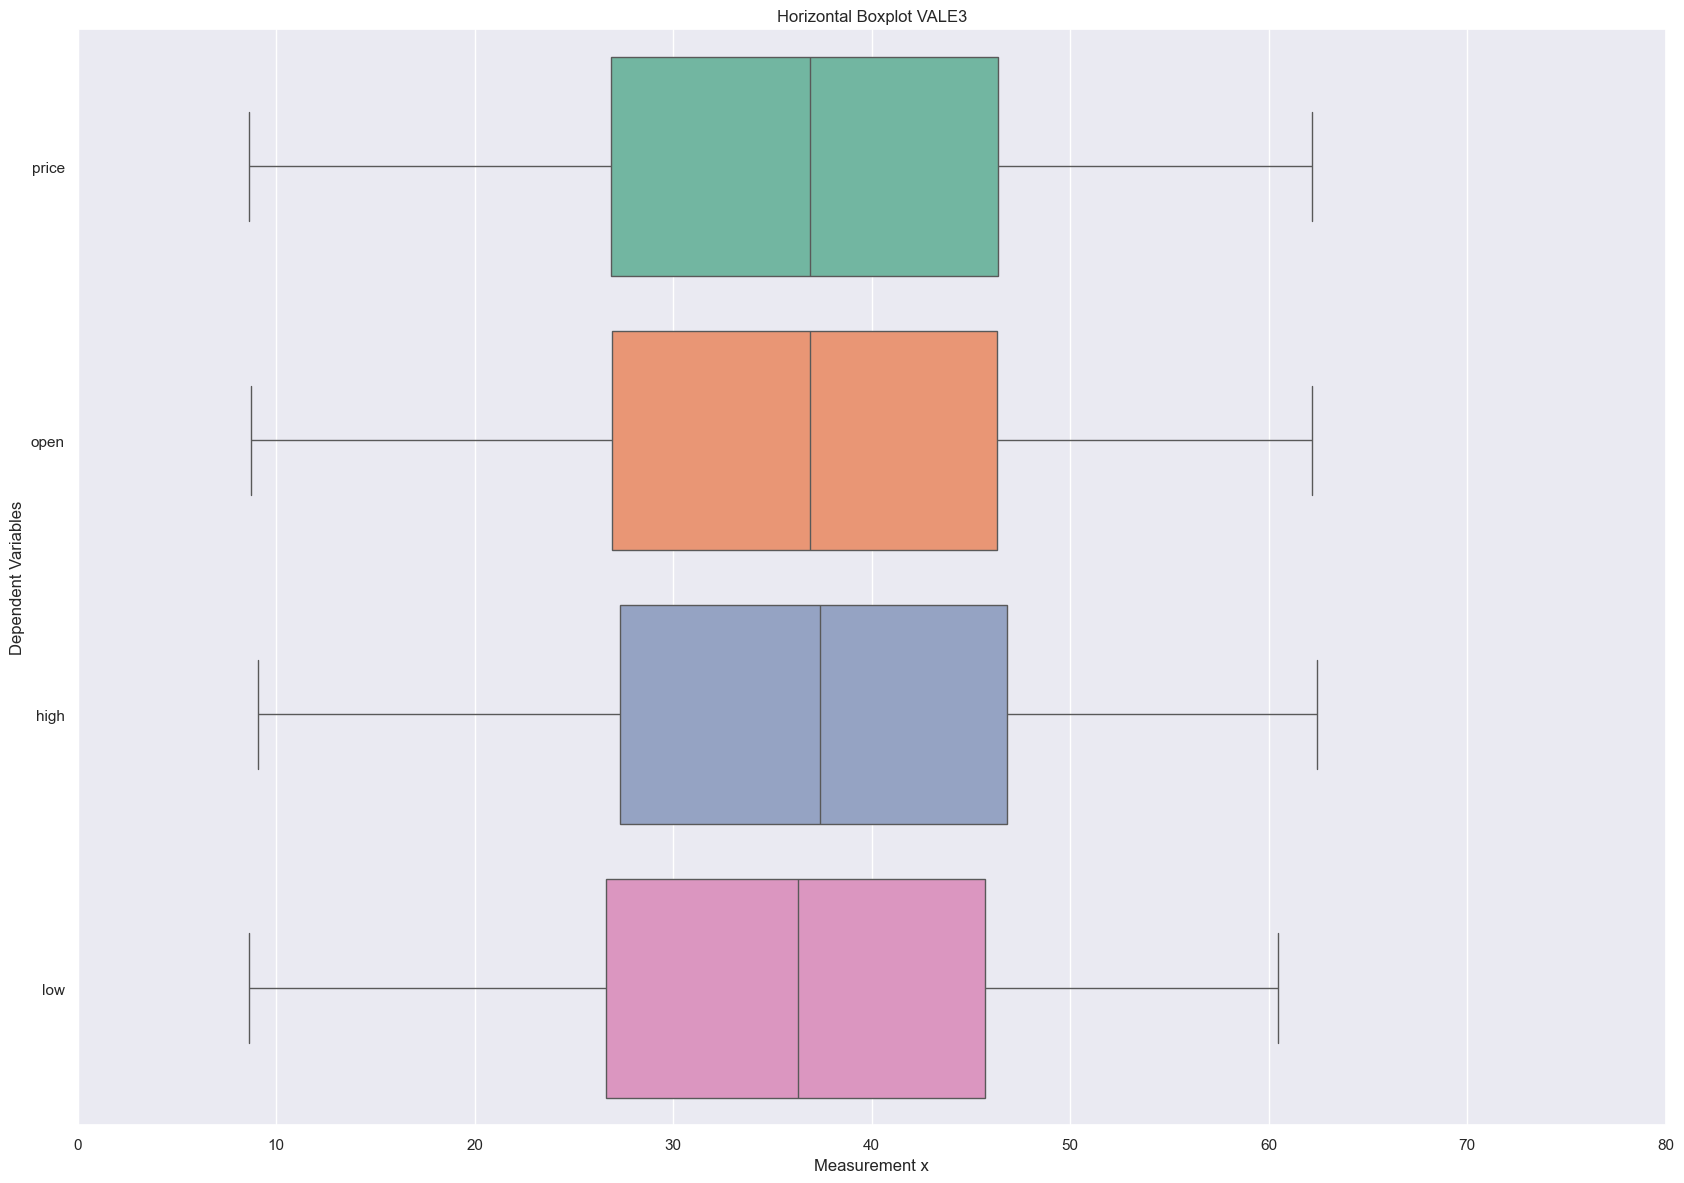

In [24]:
plot_box_plot(df_vale3, 'VALE3', (0, 80))

## **h. Data Understanding: Statistics and Plot**
### **Data Explorate**
- Analysis of Time Series Components
- Distribution
- Seasonality
- Trend
- Noise

### i. **Distribution**

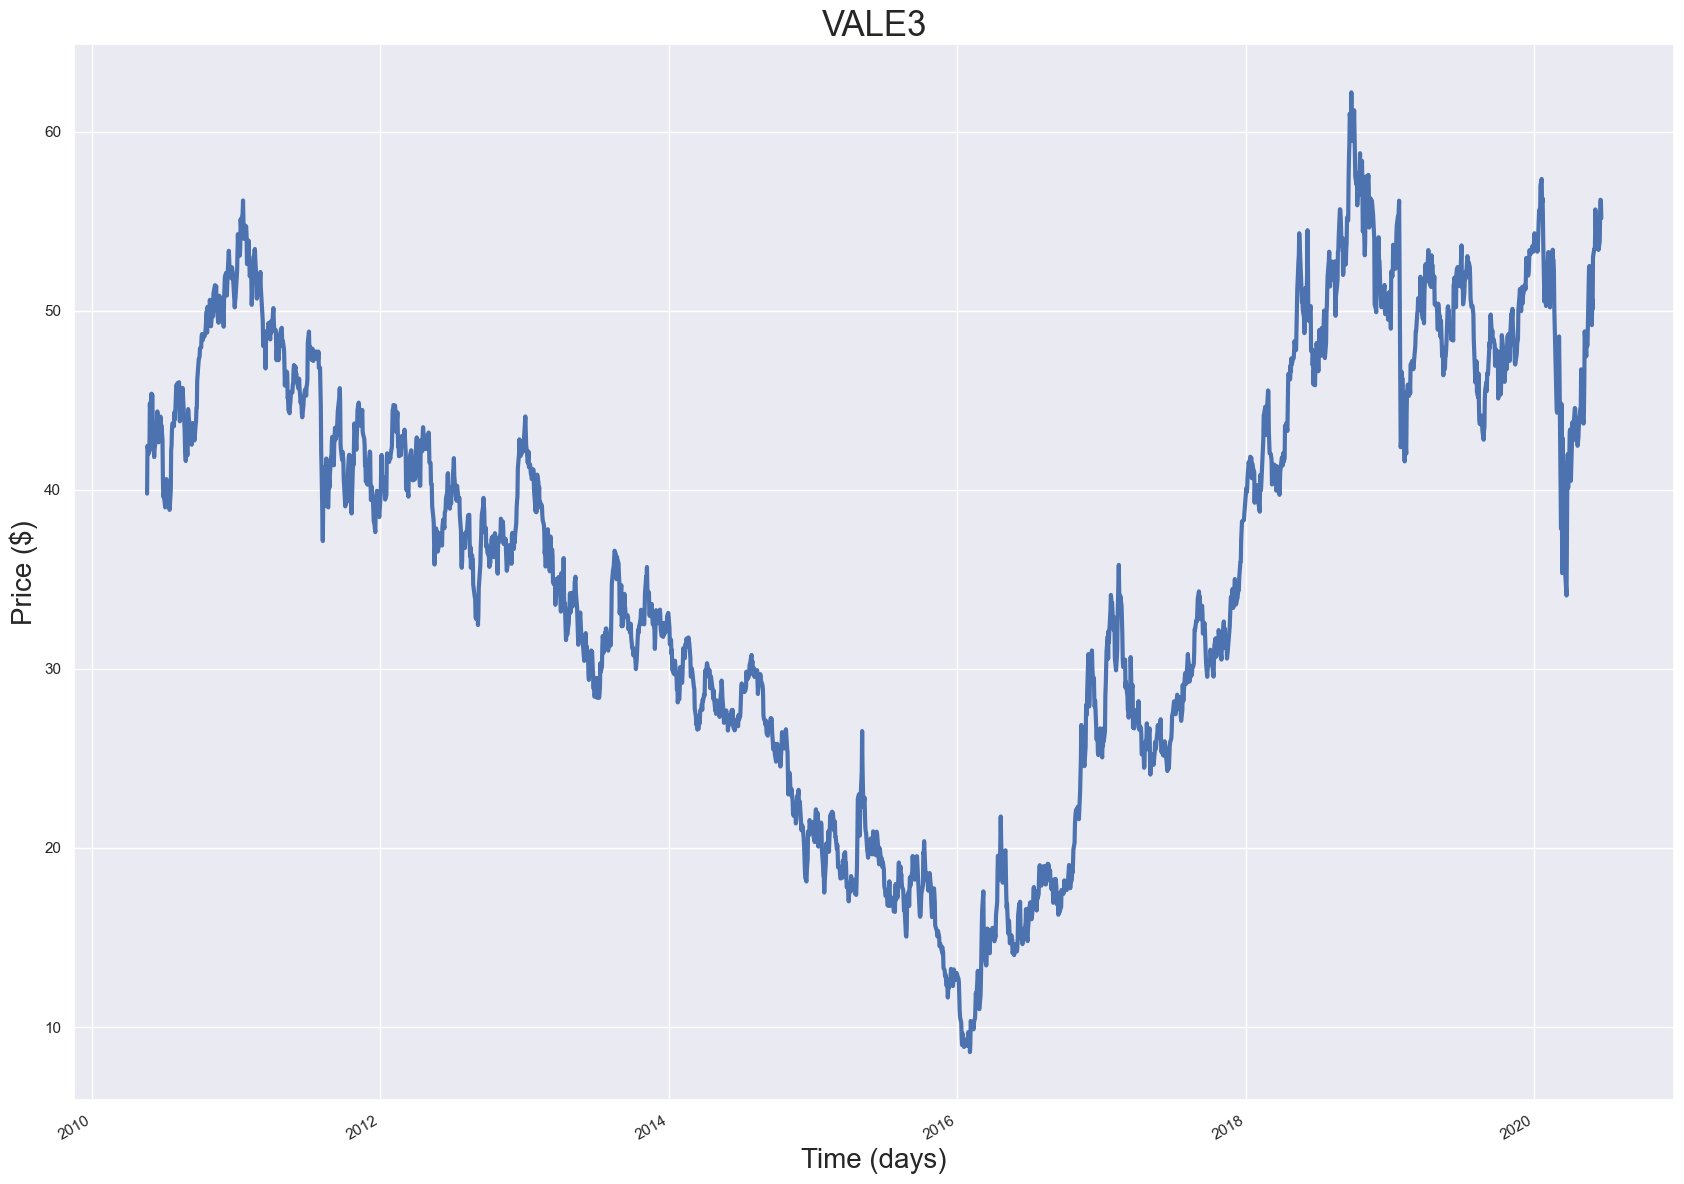

In [25]:
img_vale3_distr_line = df_vale3_date_index['price'].plot(linewidth=3)

plt.title(f'VALE3', fontsize=25)
plt.xlabel("Time (days)", fontsize=20)
plt.ylabel("Price ($)", fontsize=20)
plt.grid(True)

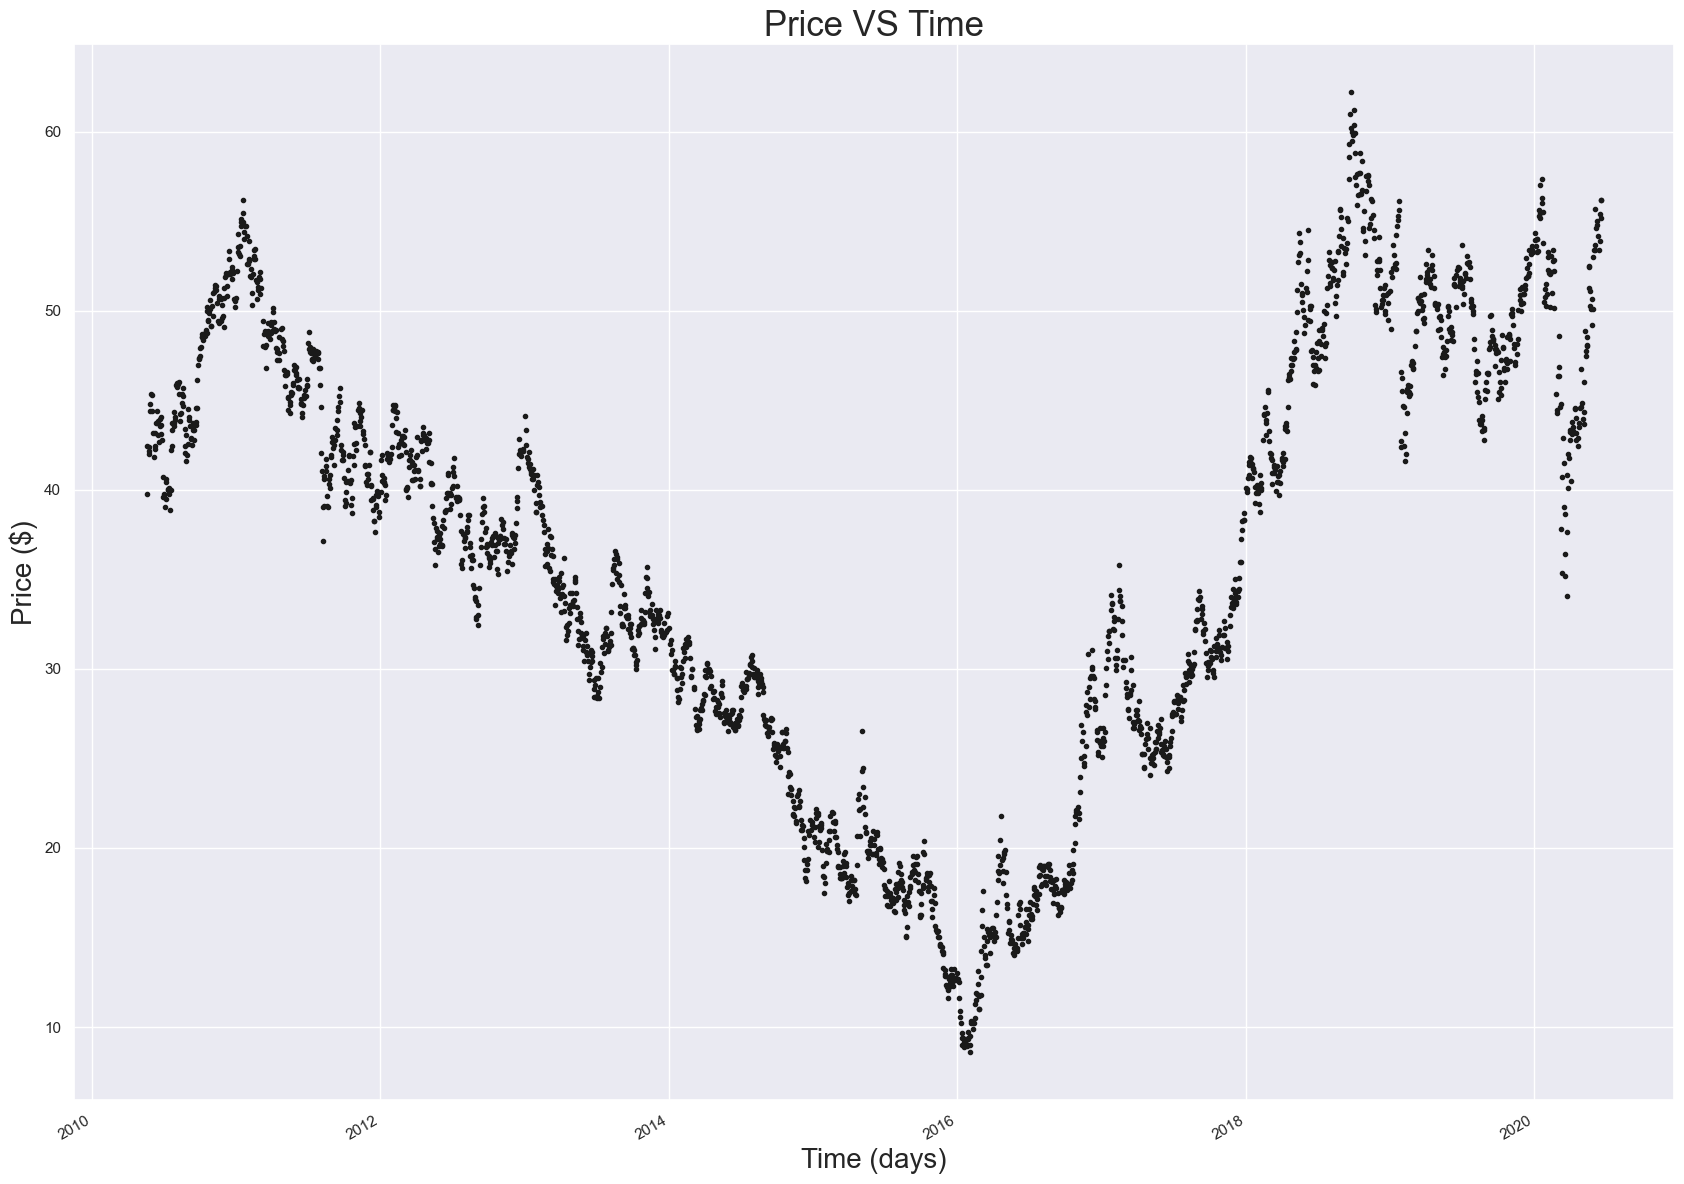

In [26]:
img_vale3_distr_scatter = df_vale3_date_index['price'].plot(style='k.')

plt.title(f'Price VS Time', fontsize=25)
plt.xlabel("Time (days)", fontsize=20)
plt.ylabel("Price ($)", fontsize=20)
plt.grid(True)

#### **NOTES**
- There was a significant downtrend, beginning after reaching the peak and lasting approximately 500 days.
- Following the downtrend reaching its bottom, there was a reversal, initiating an uptrend cycle.
- Currently, it appears to be in a consolidation phase.

### **ii. Time Series Decomposition**
- The objective is to decompose the time series (ST).
- The time series appears to exhibit two trends, both cases showing a linear rather than exponential trend. Therefore, the decomposition will be `additive`.

In [27]:
df_vale3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2495 entries, 2010-05-20 to 2020-06-19
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2495 non-null   datetime64[ns]
 1   price     2495 non-null   float64       
 2   open      2495 non-null   float64       
 3   high      2495 non-null   float64       
 4   low       2495 non-null   float64       
 5   vol.      2495 non-null   object        
 6   change %  2495 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 155.9+ KB


In [28]:
decomposition_add = seasonal_decompose(df_vale3['price'], period=30, model='multiplicative')

trend = decomposition_add.trend
seasonal = decomposition_add.seasonal
residual = decomposition_add.resid

<Axes: xlabel='date', ylabel='Residual'>

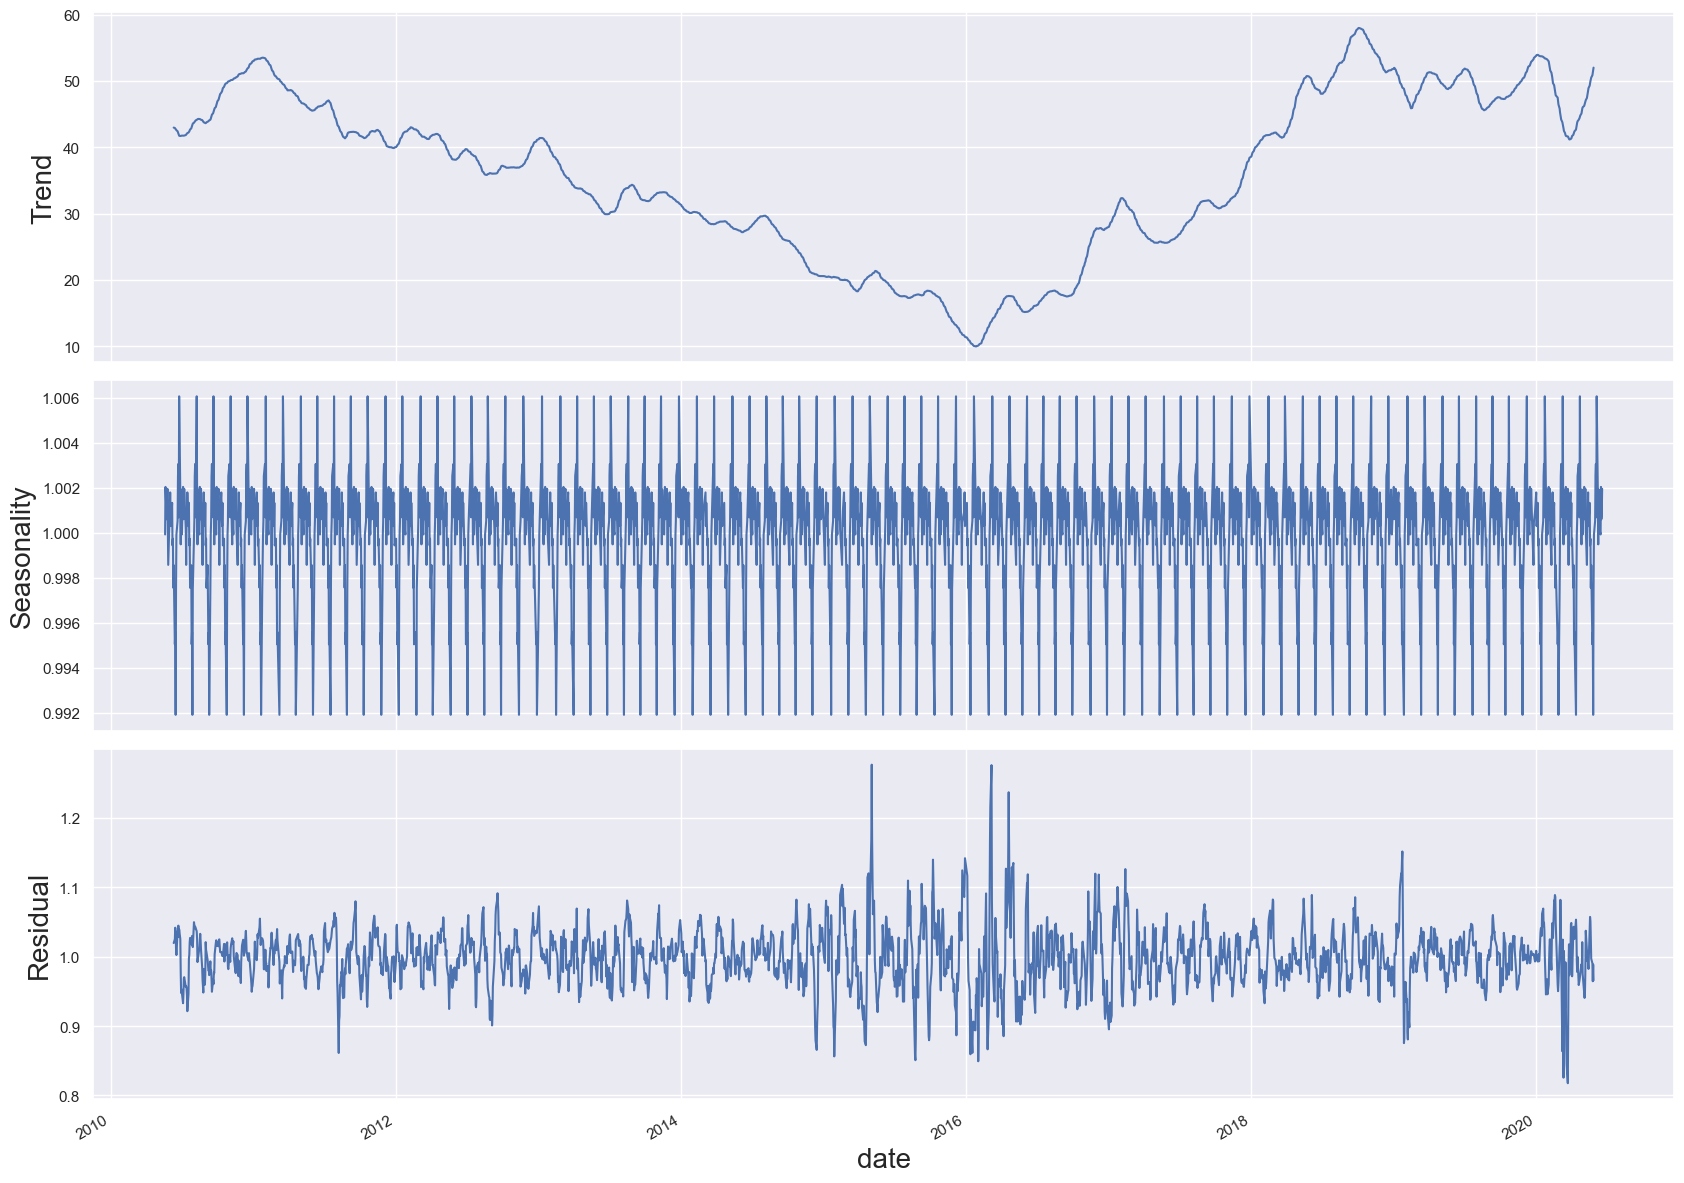

In [29]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True)

axes[0].set_ylabel('Trend', fontsize=20)
axes[1].set_ylabel('Seasonality', fontsize=20)
axes[2].set_ylabel('Residual', fontsize=20)
axes[2].set_xlabel('Time Days', fontsize=20)

decomposition_add.trend.plot(ax=axes[0])
decomposition_add.seasonal.plot(ax=axes[1])
decomposition_add.resid.plot(ax=axes[2])

# fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True)

# axes[0].set_ylabel('Trend', fontsize=20)
# axes[1].set_ylabel('Seasonality', fontsize=20)
# axes[2].set_ylabel('Residual', fontsize=20)
# axes[2].set_xlabel('Time (Days)', fontsize=20)

# decomposition_add.trend.plot(ax=axes[0])
# decomposition_add.seasonal.plot(ax=axes[1])
# decomposition_add.resid.plot(ax=axes[2])


NOTES:

The time series decomposition reveals:
- There have been 2 major trends, and in recent years, the price does not exhibit a clear trend.
- Seasonality occurs every 30 days.
- It is notable that from 2018 onwards, the residuals have increased. During this same period, the time series did not exhibit a clear trend.

### **iii. Auto-correlation**
Autoregressive models like ARIMA assume that previous observations are useful for predicting the value of the next time step.
The stronger the correlation between the output variable and a specific lagged variable, the more weight the autoregressive model can place on that variable.

NOTES:
- Correlation is calculated between the variable and itself at previous time steps, hence the name autocorrelation.
- Calculating correlation can also help in selecting which lagged variables will be useful in a model and which will not.
- If lagged variables show low or no correlation with the output variable, the time series may not be predictable.
- Used Pearson correlation.

#### wikipedia
Autocorrelation analysis is a mathematical tool used to identify repetitive patterns, such as the presence of a periodic signal obscured by noise or the identification of the fundamental frequency absent in a signal implied by its harmonic frequencies. It is commonly employed in signal processing to analyze functions or series of values, such as signals in the time domain.

In [30]:
df_vale3_date_index['price'].autocorr(lag=1)

0.9972513584845024

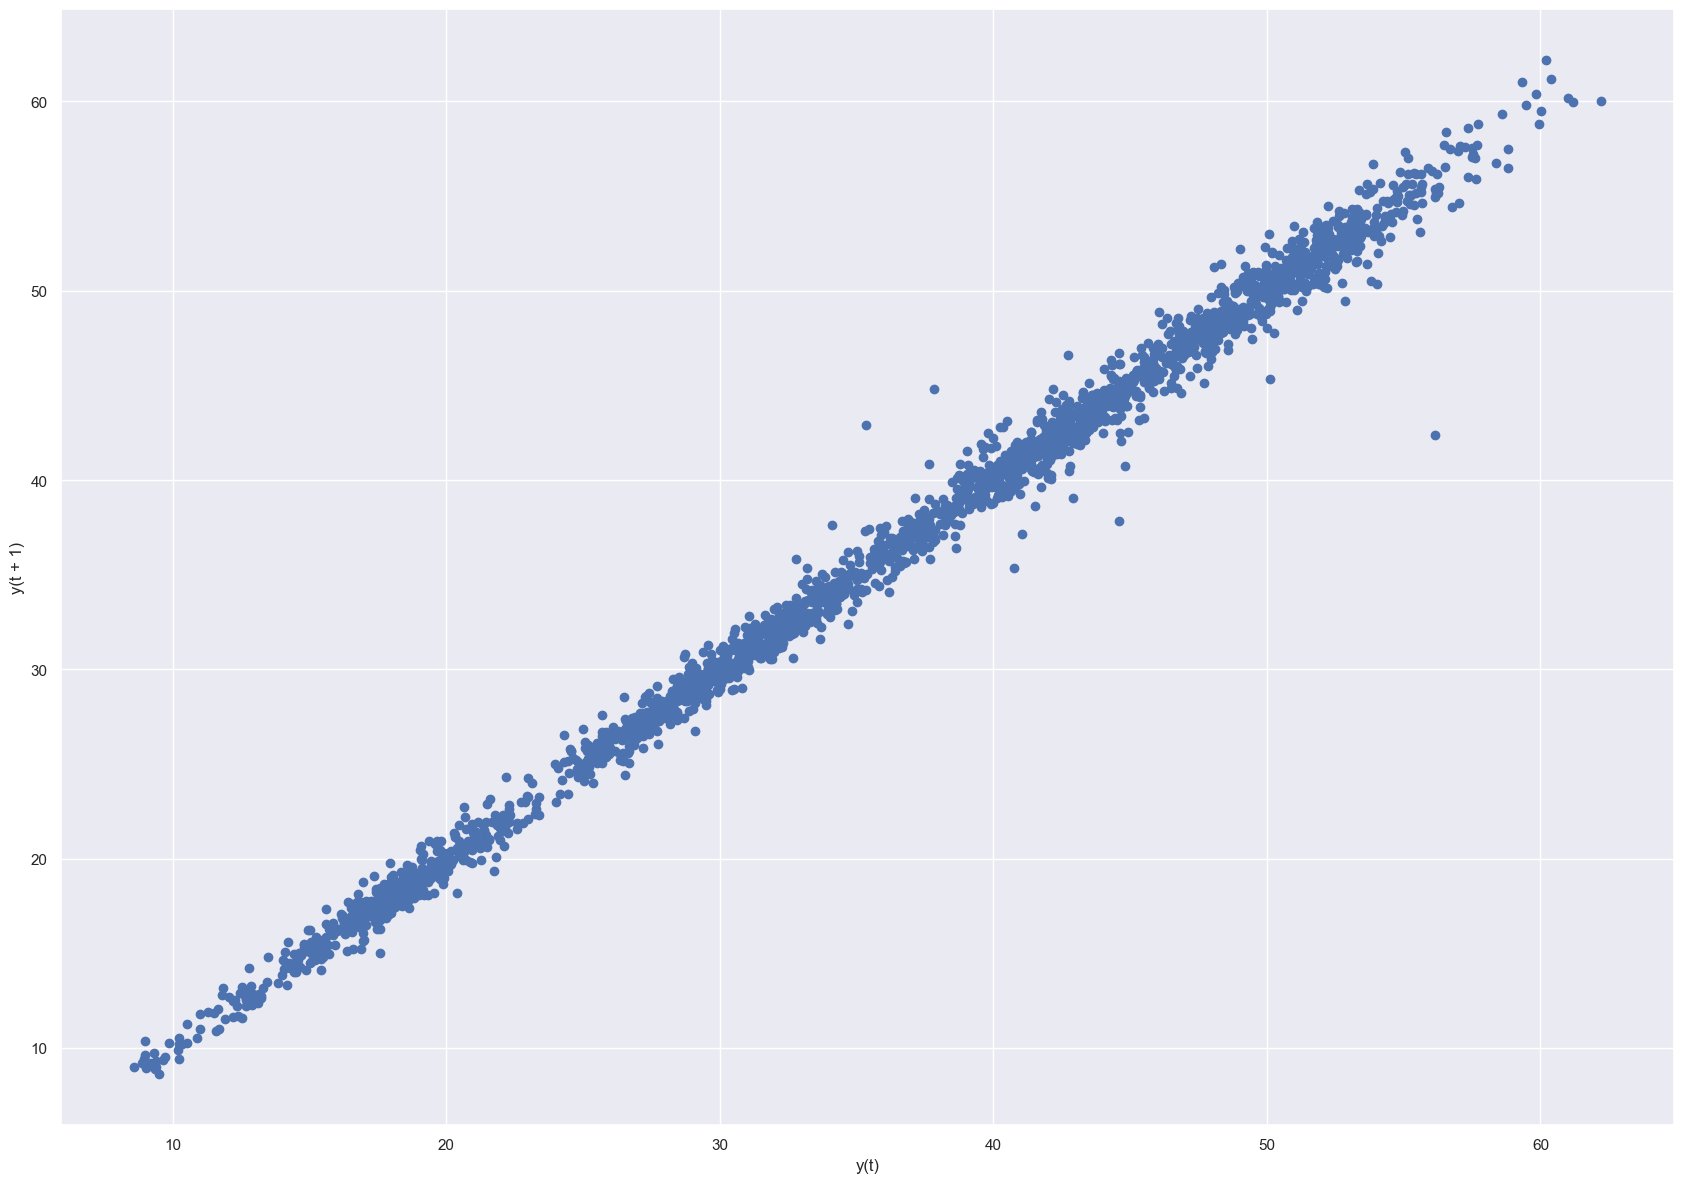

In [31]:
img_df_vale3_autocorr_1 = lag_plot(df_vale3_date_index['price'], lag=1)
# save_image(img=img_df_vale3_autocorr_1, name='img_df_vale3_autocorr_1')

In [32]:
df_vale3_date_index['price'].autocorr(lag=30)

0.9459357661702154

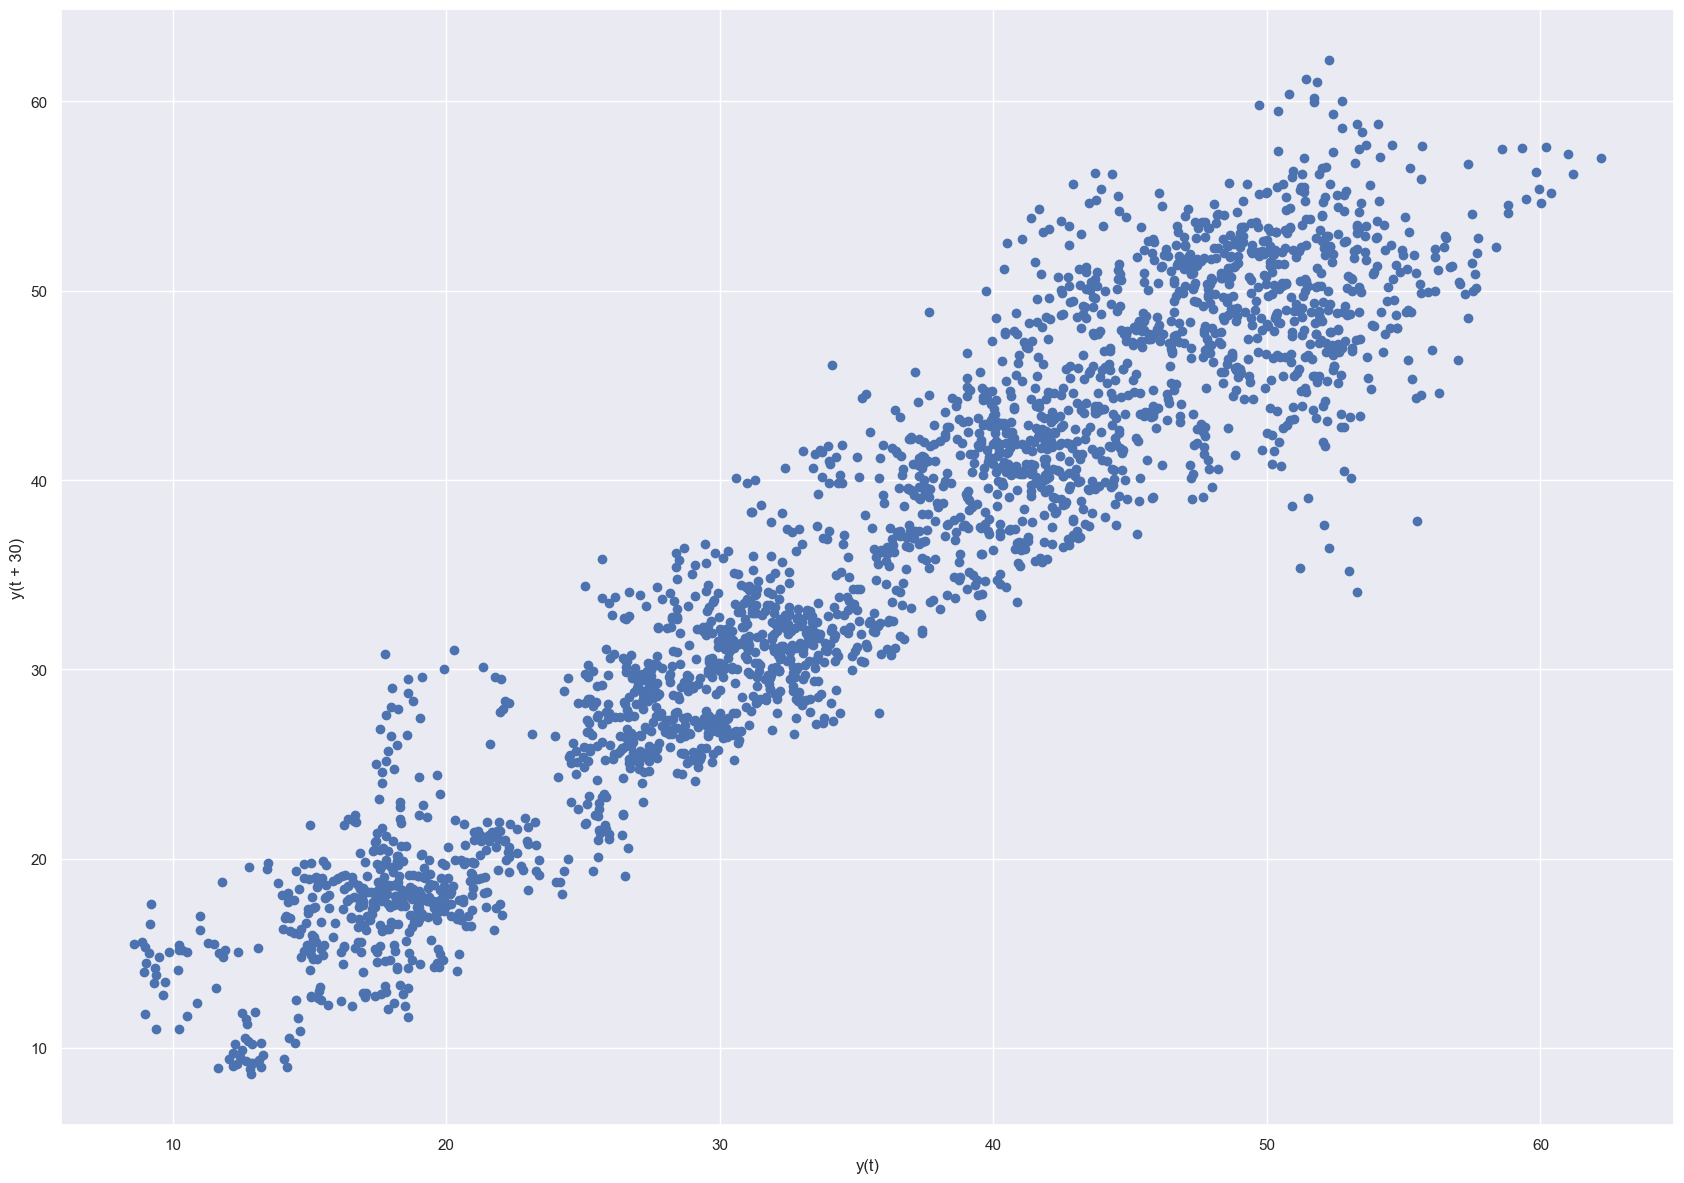

In [33]:
img_df_vale3_autocorr = lag_plot(df_vale3_date_index['price'], lag=30)

In [34]:
df_vale3_date_index['price'].autocorr(lag=313)

0.5017662028027128

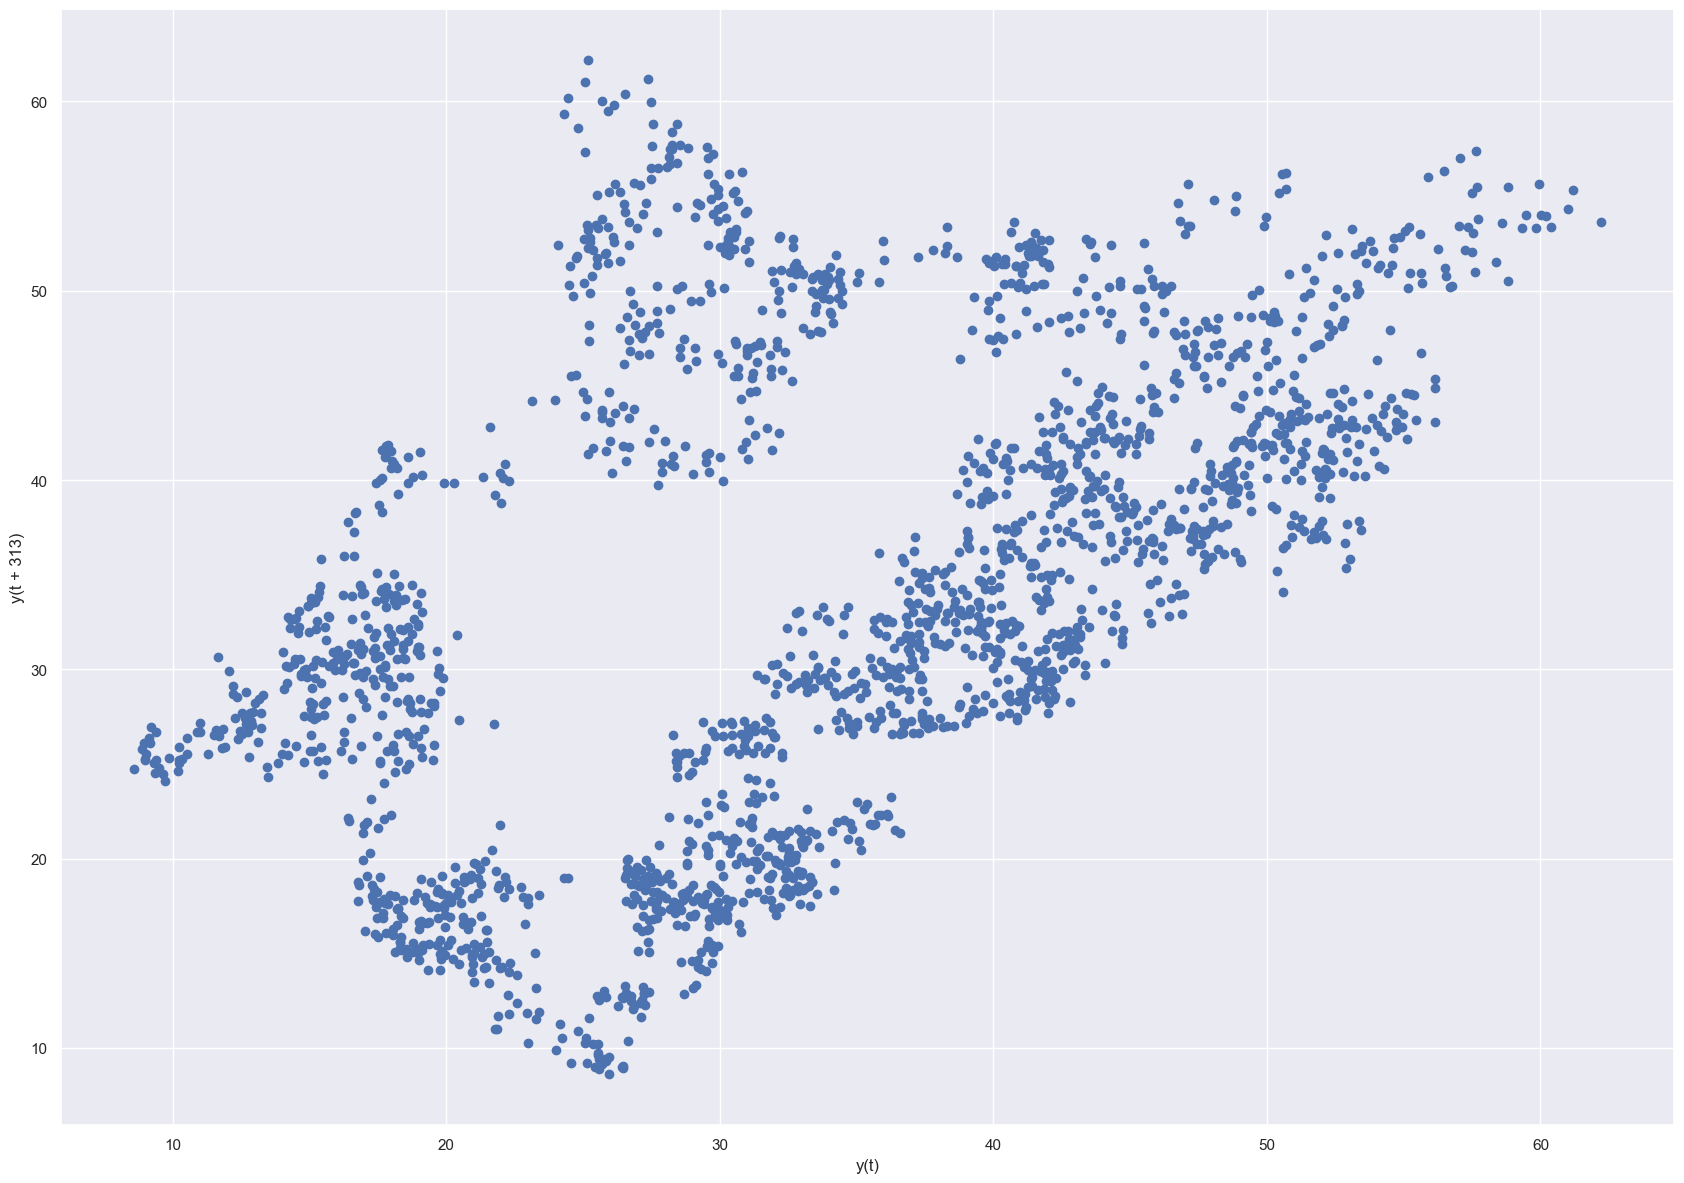

In [35]:
img_df_vale3_autocorr_313 = lag_plot(df_vale3_date_index['price'], lag=313)

In [36]:
df_vale3_date_index['price'].autocorr(lag=314)

0.49925706901065003

There is still a correlation present up to 314 days.

### **iv.Show lag variable**

In [37]:
df_vale3_original_lag_30 = pd.concat([df_vale3_date_index['price'],
                                     df_vale3_date_index['price'].shift(30)], axis=1)

In [38]:
df_vale3_original_lag_30.head(50)

,price,price
date,,
2010-05-20,39.79,NaN
2010-05-21,42.46,NaN
2010-05-24,42.02,NaN
2010-05-25,42.39,NaN
2010-05-26,42.17,NaN
2010-05-27,44.82,NaN
2010-05-28,44.42,NaN
2010-05-31,45.37,NaN
2010-06-01,44.39,NaN


We can observe a large cluster of data points along a diagonal line, indicating a clear relationship or correlation.

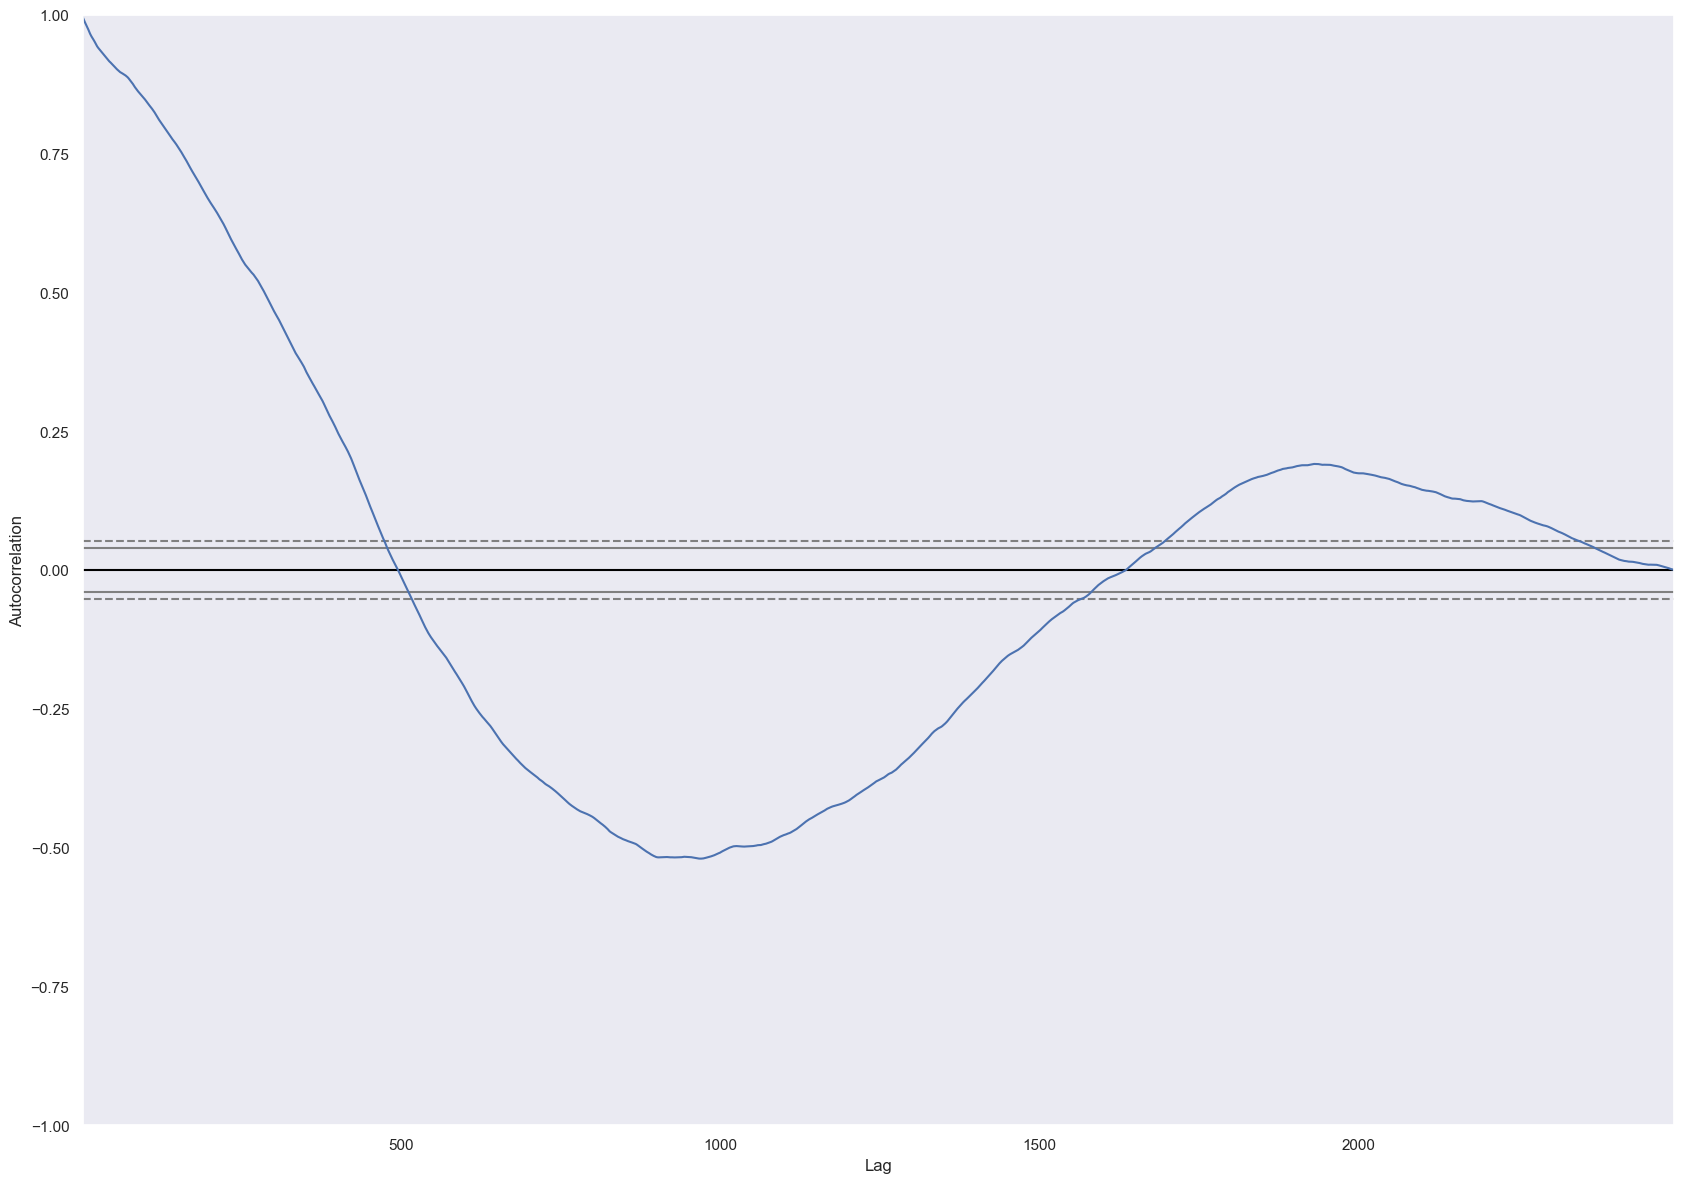

In [39]:
img_df_vale3_autocorr_time = autocorrelation_plot(df_vale3_date_index['price'])

The confidence intervals are set at 95% and 99%, suggesting that correlation values outside of these intervals are highly likely to be genuine correlations rather than statistical coincidences.

### **v. Stationarity**
It's crucial to ensure that the data is stationary. This means that the time series exhibits a consistent behavior over time and is highly likely to continue this behavior in the future. Visually, the series isn't stationary. To confirm the behavior of this series, I will plot rolling statistics (mean, variance) and conduct the Dickey-Fuller test.

So, in this test, I evaluate two hypotheses:
- Null hypothesis (H0): it is non-stationary. It has some time-dependent structure.
- Alternative hypothesis (H1): it is stationary. It does not have a time-dependent structure.

In [40]:
type(df_vale3['price'])

pandas.core.series.Series

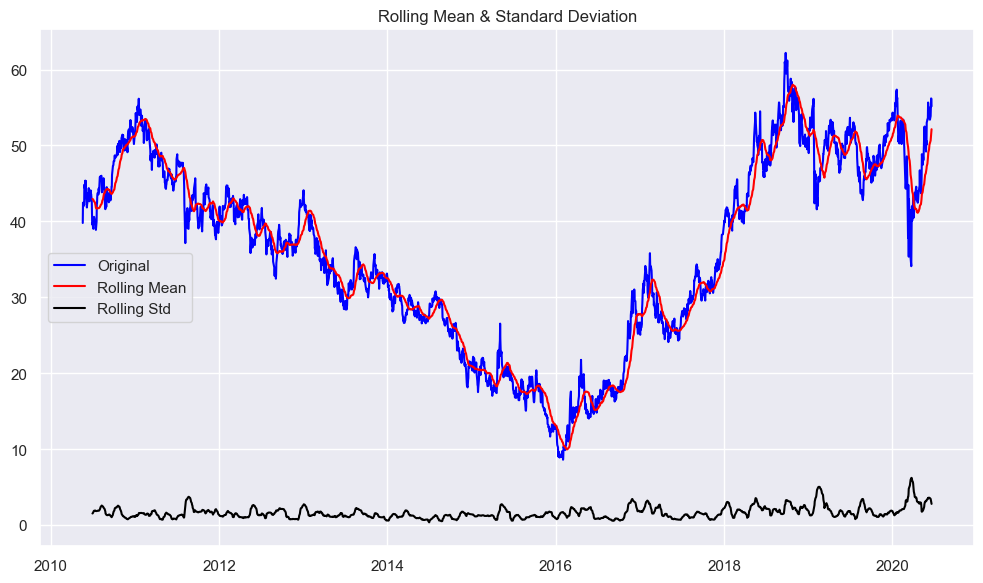

Results of Dickey-Fuller Test:
Test Statistic                  -0.93
p-value                          0.78
Lags Used                       27.00
Number of Observations Used   2467.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [41]:
test_stationary(df_vale3['price'])

**NOTES**
<br/>
- We used **autolag='AIC'** to let the function determine the lag, selecting the lowest observed value.
- **Test Statistic > Critical Value (1%)**: hence, H0 is accepted, indicating non-stationarity in the explored time series.
- In this case, it's necessary to make the time series stationary!

### **vi. Stationarity through Decomposition**

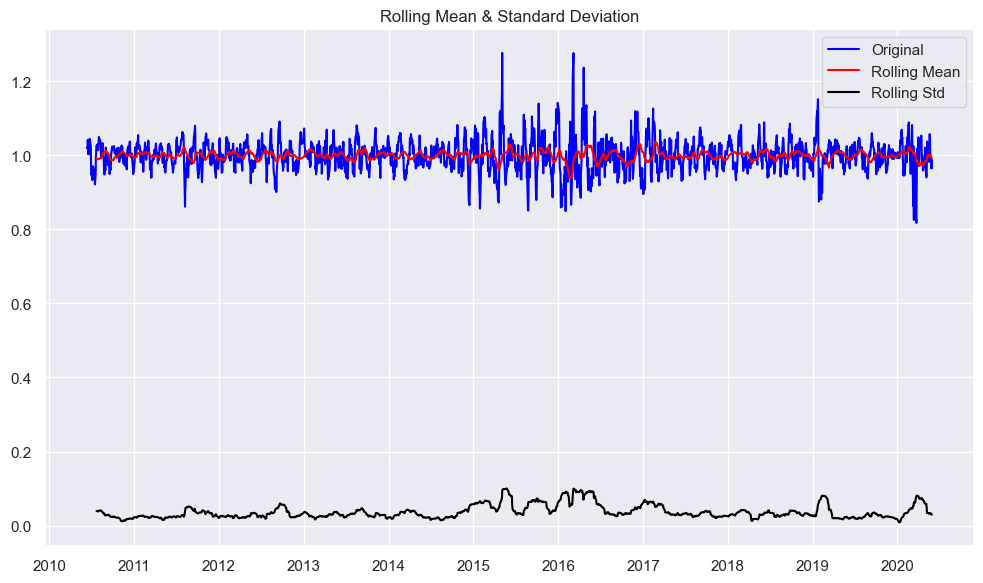

Results of Dickey-Fuller Test:
Test Statistic                 -12.43
p-value                          0.00
Lags Used                       27.00
Number of Observations Used   2437.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [42]:
residual
residual.dropna(inplace=True)
test_stationary(residual)

## **i. Data Preparation: Feature Engineering**

In [43]:
cols = ['data', 'price', 'residuals', 'trend', 'seasonality']
df = pd.DataFrame(columns=cols)
df.head()

,data,price,residuals,trend,seasonality


In [44]:
df['data'] = df_vale3['date']
df.head()

,data,price,residuals,trend,seasonality
date,,,,,
2010-05-20,2010-05-20,NaN,NaN,NaN,NaN
2010-05-21,2010-05-21,NaN,NaN,NaN,NaN
2010-05-24,2010-05-24,NaN,NaN,NaN,NaN
2010-05-25,2010-05-25,NaN,NaN,NaN,NaN
2010-05-26,2010-05-26,NaN,NaN,NaN,NaN


In [45]:
df['price'] = df_vale3['price']
df.head()

,data,price,residuals,trend,seasonality
date,,,,,
2010-05-20,2010-05-20,39.79,NaN,NaN,NaN
2010-05-21,2010-05-21,42.46,NaN,NaN,NaN
2010-05-24,2010-05-24,42.02,NaN,NaN,NaN
2010-05-25,2010-05-25,42.39,NaN,NaN,NaN
2010-05-26,2010-05-26,42.17,NaN,NaN,NaN


In [46]:
df['trend'] = trend.values
df.head(20)

,data,price,residuals,trend,seasonality
date,,,,,
2010-05-20,2010-05-20,39.79,NaN,NaN,NaN
2010-05-21,2010-05-21,42.46,NaN,NaN,NaN
2010-05-24,2010-05-24,42.02,NaN,NaN,NaN
2010-05-25,2010-05-25,42.39,NaN,NaN,NaN
2010-05-26,2010-05-26,42.17,NaN,NaN,NaN
2010-05-27,2010-05-27,44.82,NaN,NaN,NaN
2010-05-28,2010-05-28,44.42,NaN,NaN,NaN
2010-05-31,2010-05-31,45.37,NaN,NaN,NaN
2010-06-01,2010-06-01,44.39,NaN,NaN,NaN


In [47]:
df['seasonality'] = seasonal.values
df.head(20)

,data,price,residuals,trend,seasonality
date,,,,,
2010-05-20,2010-05-20,39.79,NaN,NaN,1.00
2010-05-21,2010-05-21,42.46,NaN,NaN,1.00
2010-05-24,2010-05-24,42.02,NaN,NaN,1.00
2010-05-25,2010-05-25,42.39,NaN,NaN,1.00
2010-05-26,2010-05-26,42.17,NaN,NaN,1.00
2010-05-27,2010-05-27,44.82,NaN,NaN,1.00
2010-05-28,2010-05-28,44.42,NaN,NaN,1.00
2010-05-31,2010-05-31,45.37,NaN,NaN,1.00
2010-06-01,2010-06-01,44.39,NaN,NaN,1.00


In [48]:
residual = residual.values

df = df[30:]
df['residuals'] = residual
df.head()

,data,price,residuals,trend,seasonality
date,,,,,
2010-07-02,2010-07-02,39.58,1.02,41.75,1.00
2010-07-05,2010-07-05,39.02,1.03,41.74,1.00
2010-07-06,2010-07-06,39.51,1.04,41.74,1.00
2010-07-07,2010-07-07,40.46,1.03,41.74,1.00
2010-07-08,2010-07-08,40.60,1.01,41.76,1.00


In [49]:
df['diff_1'] = df['price'].diff(periods=1)
df['diff_2'] = df['price'].diff(periods=2)
df['diff_3'] = df['price'].diff(periods=3)
df['diff_4'] = df['price'].diff(periods=4)
df['diff_5'] = df['price'].diff(periods=5)

df.dropna(inplace=True)
df.head(10)

,data,price,residuals,trend,seasonality,diff_1,diff_2,diff_3,diff_4,diff_5
date,,,,,,,,,,
2010-07-12,2010-07-12,40.00,1.00,41.83,1.00,-0.60,-0.46,0.49,0.98,0.42
2010-07-13,2010-07-13,40.07,1.04,41.91,1.00,0.07,-0.53,-0.39,0.56,1.05
2010-07-14,2010-07-14,40.08,1.03,41.98,1.00,0.01,0.08,-0.52,-0.38,0.57
2010-07-15,2010-07-15,39.76,1.04,42.05,1.00,-0.32,-0.31,-0.24,-0.84,-0.70
2010-07-16,2010-07-16,38.88,1.03,42.12,1.00,-0.88,-1.20,-1.19,-1.12,-1.72
2010-07-19,2010-07-19,39.97,1.04,42.21,1.00,1.09,0.21,-0.11,-0.10,-0.03
2010-07-20,2010-07-20,42.23,1.03,42.29,1.00,2.26,3.35,2.47,2.15,2.16
2010-07-21,2010-07-21,42.47,0.98,42.39,1.00,0.24,2.50,3.59,2.71,2.39
2010-07-22,2010-07-22,43.37,0.95,42.51,1.00,0.90,1.14,3.40,4.49,3.61


In [50]:
save_dataframe(df=df, path='data/df_vale3_cleansing.csv')

Saved data at data/df_vale3_cleansing.csv


---

# **2. Econometric Models**

Model Used 

- AR
- ARIMA
- SARIMA

In [51]:
%%time
df_vale3 = pd.read_csv('Data/df_vale3_cleansing.csv', encoding='utf8', delimiter=',', parse_dates=True, index_col=0, verbose=True)
df_vale3.head(10)

Tokenization took: 0.92 ms
Type conversion took: 1.10 ms
Parser memory cleanup took: 0.00 ms
CPU times: user 4.23 ms, sys: 1.82 ms, total: 6.05 ms
Wall time: 5.58 ms


,price,residuals,trend,seasonality,diff_1,diff_2,diff_3,diff_4,diff_5
data,,,,,,,,,
2010-07-12,40.00,1.00,41.83,1.00,-0.60,-0.46,0.49,0.98,0.42
2010-07-13,40.07,1.04,41.91,1.00,0.07,-0.53,-0.39,0.56,1.05
2010-07-14,40.08,1.03,41.98,1.00,0.01,0.08,-0.52,-0.38,0.57
2010-07-15,39.76,1.04,42.05,1.00,-0.32,-0.31,-0.24,-0.84,-0.70
2010-07-16,38.88,1.03,42.12,1.00,-0.88,-1.20,-1.19,-1.12,-1.72
2010-07-19,39.97,1.04,42.21,1.00,1.09,0.21,-0.11,-0.10,-0.03
2010-07-20,42.23,1.03,42.29,1.00,2.26,3.35,2.47,2.15,2.16
2010-07-21,42.47,0.98,42.39,1.00,0.24,2.50,3.59,2.71,2.39
2010-07-22,43.37,0.95,42.51,1.00,0.90,1.14,3.40,4.49,3.61


### **a. Data Splitting**

In [52]:
size_train = 2132
size_test = 313
print(size_train)
print(size_test)

df_train = df_vale3['price'].iloc[:size_train]
df_test = df_vale3['price'].iloc[size_train:]
df_train.tail()

2132
313


data
2019-02-15   45.88
2019-02-18   45.25
2019-02-19   45.49
2019-02-20   45.80
2019-02-21   45.38
Name: price, dtype: float64

Text(0.5, 1.0, 'Training Size = 2132')

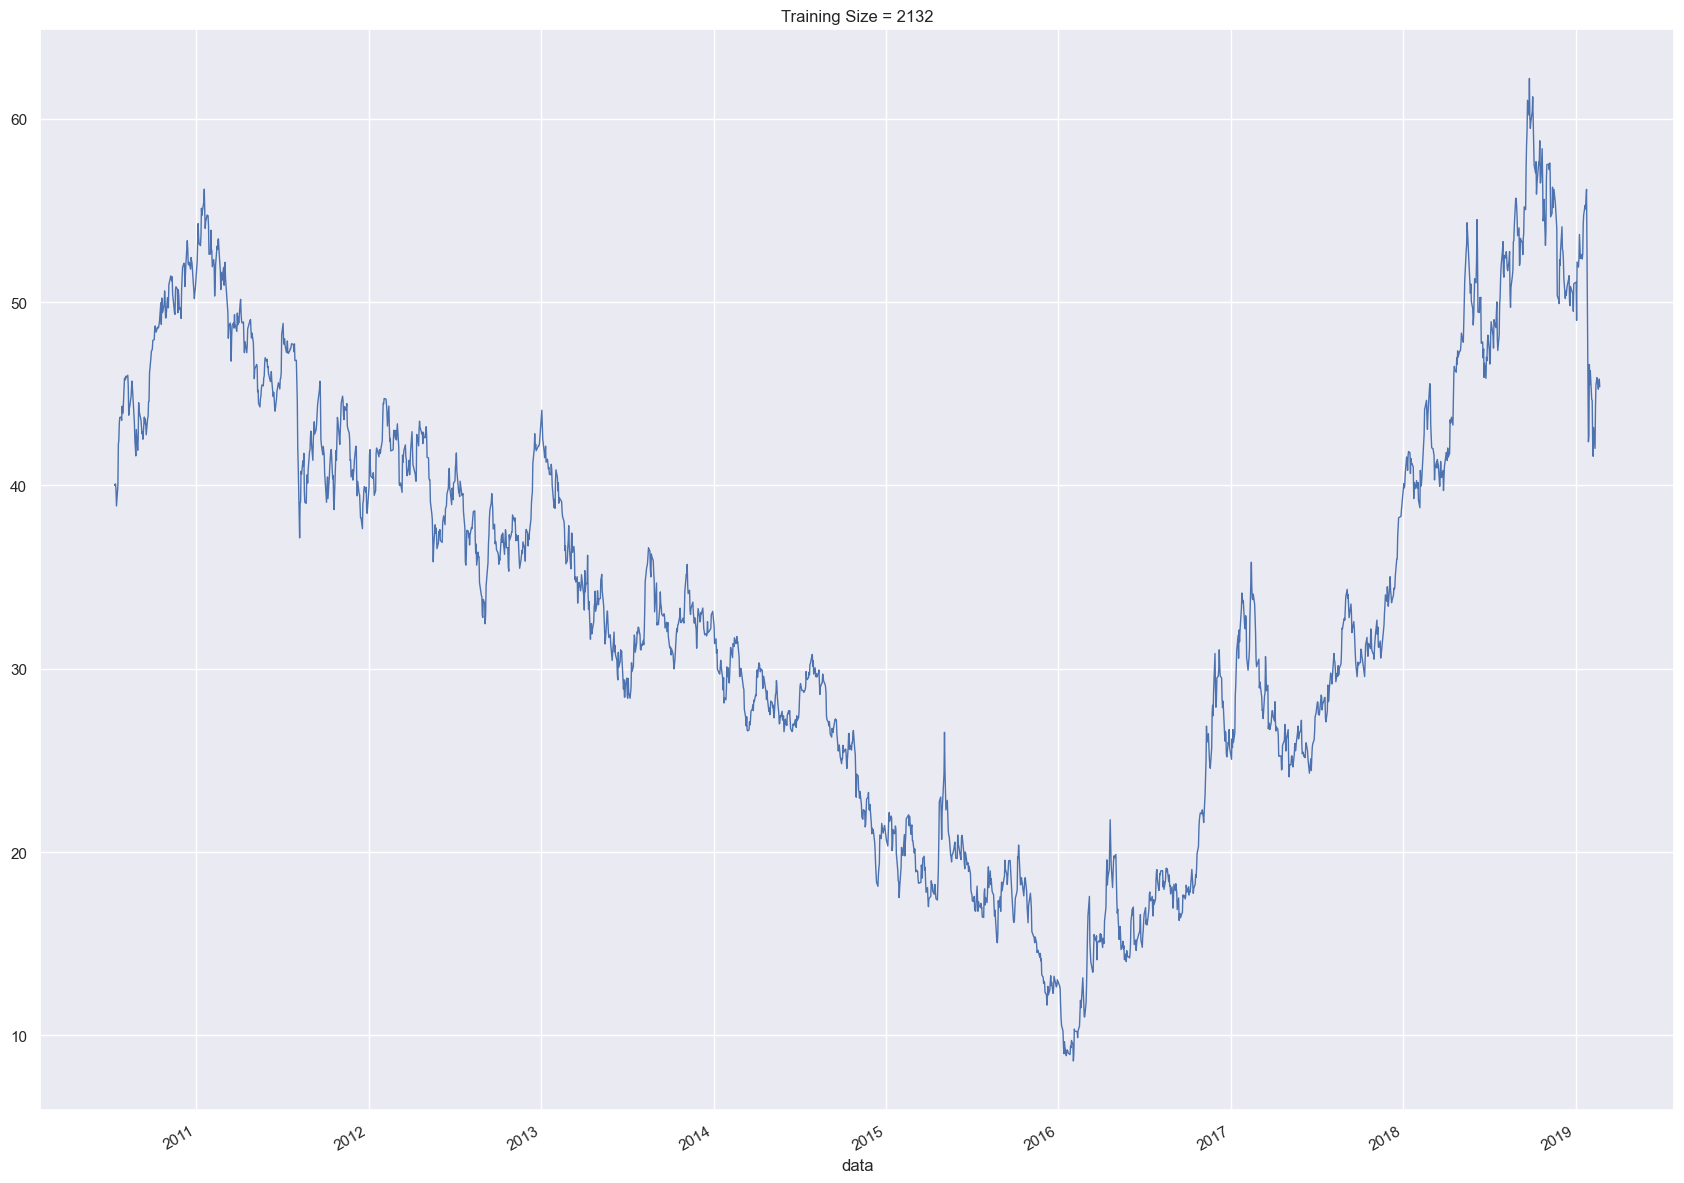

In [53]:
df_train.plot(linewidth=1)
plt.grid(True)
plt.title(f'Training Size = {len(df_train)}')

Text(0.5, 1.0, 'Test Size = 313')

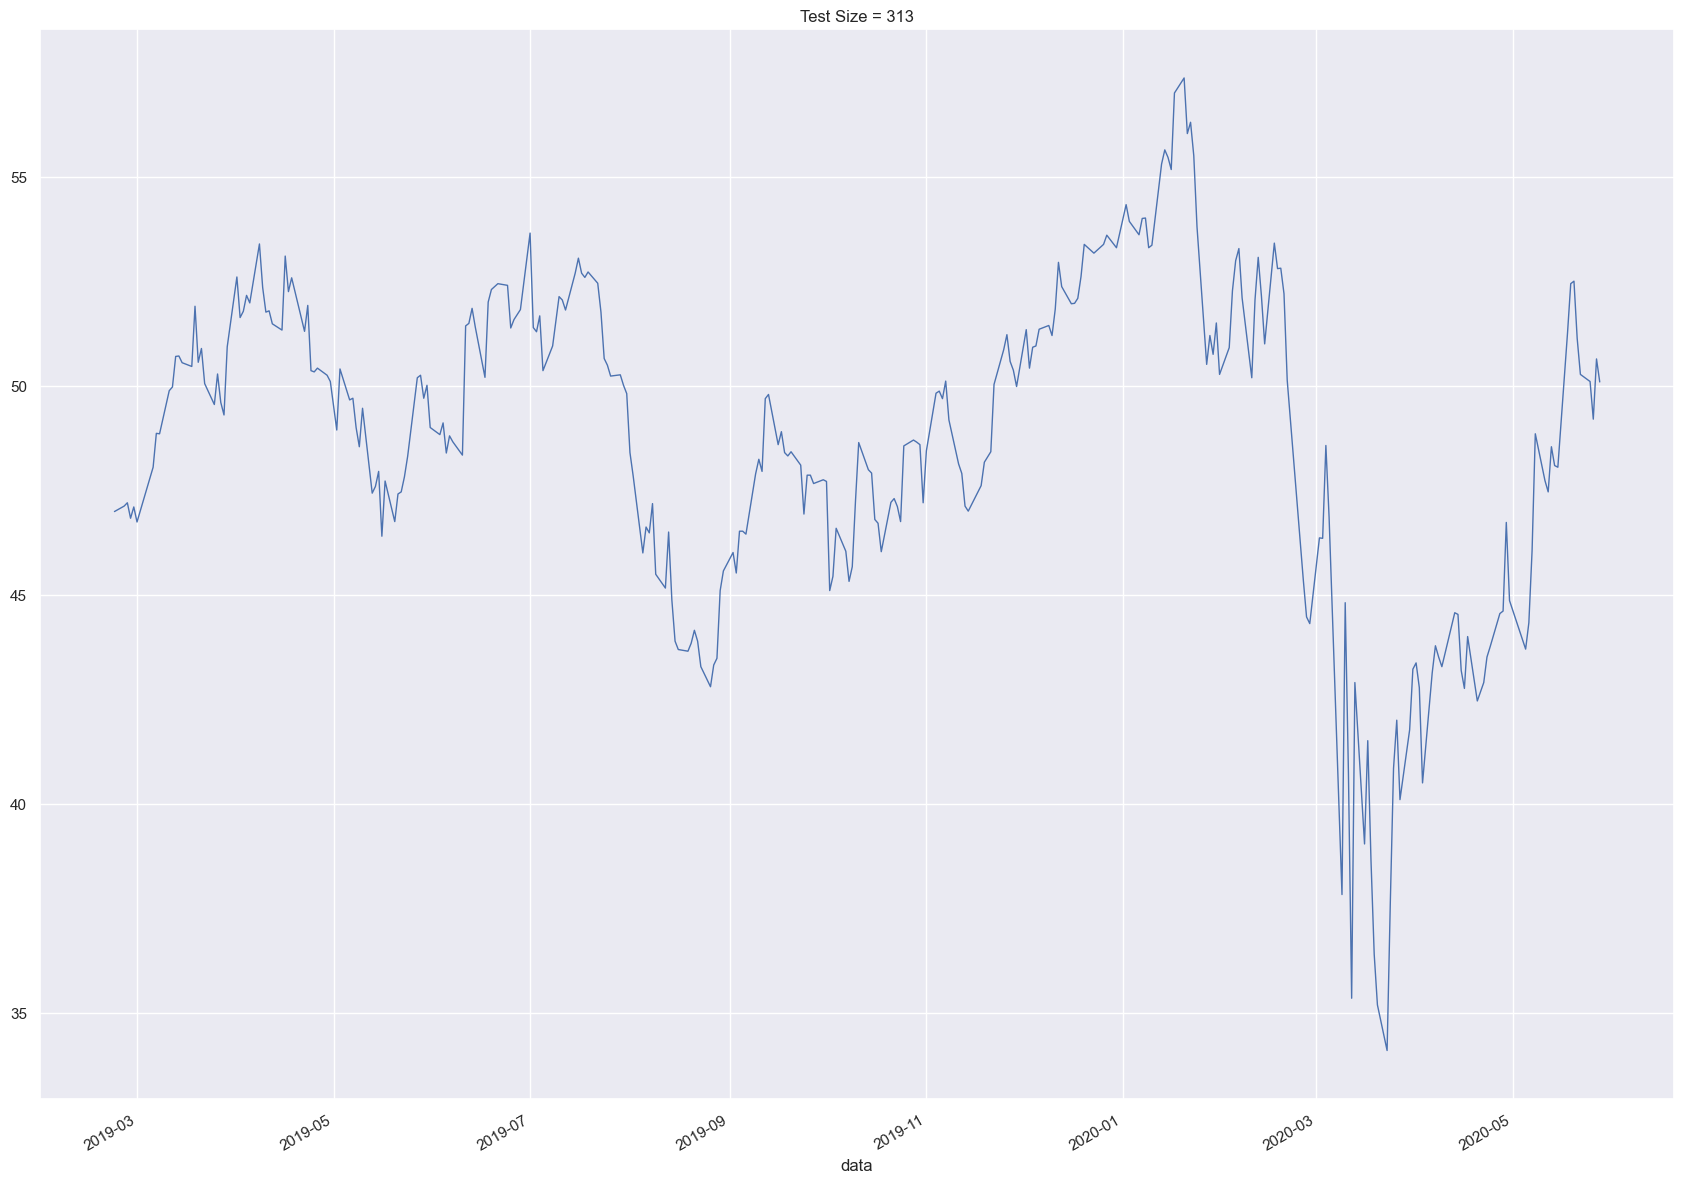

In [54]:
df_test.plot(linewidth=1)
plt.grid(True)
plt.title(f'Test Size = {len(df_test)}')

### **b. Data Indexing**

In [55]:
print("Index of train", df_train.index)
print("-------------------------------------------------------------------------------------------------------------------")
print("Index of test", df_test.index)

Index of train DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21'],
              dtype='datetime64[ns]', name='data', length=2132, freq=None)
-------------------------------------------------------------------------------------------------------------------
Index of test DatetimeIndex(['2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-01', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28'],


In [56]:
df_train.reset_index(drop=True, inplace=True)
df_train.index

RangeIndex(start=0, stop=2132, step=1)

In [57]:
df_test.reset_index(drop=True, inplace=True)
df_test.index

RangeIndex(start=0, stop=313, step=1)

In [58]:
df_train.index = pd.RangeIndex(start=0, stop=len(df_train), step=1)
df_train.index

RangeIndex(start=0, stop=2132, step=1)

In [59]:
df_test.index = pd.RangeIndex(start=2132, stop=len(df_vale3), step=1)
df_test.index

RangeIndex(start=2132, stop=2445, step=1)

### **c. Evaluation**

In [60]:
dict_results = {}

#### **i. Grid Search**

In time series analysis and forecasting using ARIMA (AutoRegressive Integrated Moving Average) models, the choice of parameters (p, d, q) is crucial for model performance. These parameters determine the number of lag observations included in the model (p), the number of times the data is differenced to achieve stationarity (d), and the size of the moving average window (q).

For non-seasonal ARIMA models, the code generates combinations of (p, d, q), covering all permutations of lag, differencing, and moving average components. This helps in identifying the optimal combination that minimizes prediction errors and captures underlying patterns in the data.



In [61]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 3)
d = range(0, 3)

# Generate all different combinations of p, q and q triplets
list_pdq = list(itertools.product(p, d, q))
print(f'All different combinations of p, q and q:\n {list_pdq}')

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(f'\n\nAll different combinations of seasonal p, q and q:\n {seasonal_pdq}')

All different combinations of p, q and q:
 [(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2)]


All different combinations of seasonal p, q and q:
 [(0, 0, 0, 12), (0, 0, 1, 12), (0, 0, 2, 12), (0, 1, 0, 12), (0, 1, 1, 12), (0, 1, 2, 12), (0, 2, 0, 12), (0, 2, 1, 12), (0, 2, 2, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 0, 2, 12), (1, 1, 0, 12), (1, 1, 1, 12), (1, 1, 2, 12), (1, 2, 0, 12), (1, 2, 1, 12), (1, 2, 2, 12), (2, 0, 0, 12), (2, 0, 1, 12), (2, 0, 2, 12), (2, 1, 0, 12), (2, 1, 1, 12), (2, 1, 2, 12), (2, 2, 0, 12), (2, 2, 1, 12), (2, 2, 2, 12)]


In [62]:
def search_best_params_arima_model(df_train: pd.core.frame.DataFrame, pdq: list) -> list:
    best_model = 99999
    best_params = (0, 0, 0)
    param = ()

    for param in pdq:
        try:
            arima_model = ARIMA(df_train, order=param)
            results = arima_model.fit()
            print(f'pdq = {param} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
                best_params = param
        except:
            continue

    print(f'best ARIMA: {best_params} | AIC:{best_model}')
    return [best_params, best_model]

In [63]:
def search_best_params_sarima_model(df_train: pd.core.frame.DataFrame, trend, pdq):
    best_model = 99999
    best_param_seasonal = ()
    param = ()
    param_seasonal = ()

    for param_seasonal in seasonal_pdq:
        try:
            sarima_model = SARIMAX(df_train,
                                   order=pdq,
                                   seasonal_order=param_seasonal,
                                   trend=trend,
                                   enforce_stationarity=True,
                                   enforce_invertibility=False)
            results = sarima_model.fit()
            print(f'pdq = {pdq} | param_seasonal = {param_seasonal} | AIC = {results.aic}')

            if results.aic < best_model:
                best_model = results.aic
                best_param_seasonal = param_seasonal
        except:
            continue

    print(f'\n\nBest SARIMA: {pdq}x{param_seasonal}12 | AIC:{best_model}')
    return [best_param_seasonal, best_model]

### **d. Modeling**

#### **Building Models**
#### **1. Econometric Models**
#### **1.1. Autoregressive (AR)**
- The time series (ST) is non-stationary.
- There is no trend (trend='n').
- There is no seasonality (seasonal=False) over the 30-day period.

In [64]:
ar_model = AutoReg(df_train, lags=313, trend='n', seasonal=False, period=len(df_test))
ar_fit = ar_model.fit()

In [65]:
# forecast
y_ar_forecast = ar_fit.predict(start=(df_test.index[0]), end=df_test.index[-1])

,forecast
2132,45.77
2133,44.88
2134,45.33
2135,46.79
2136,46.80
...,...
2440,44.41
2441,45.77
2442,45.11
2443,44.12


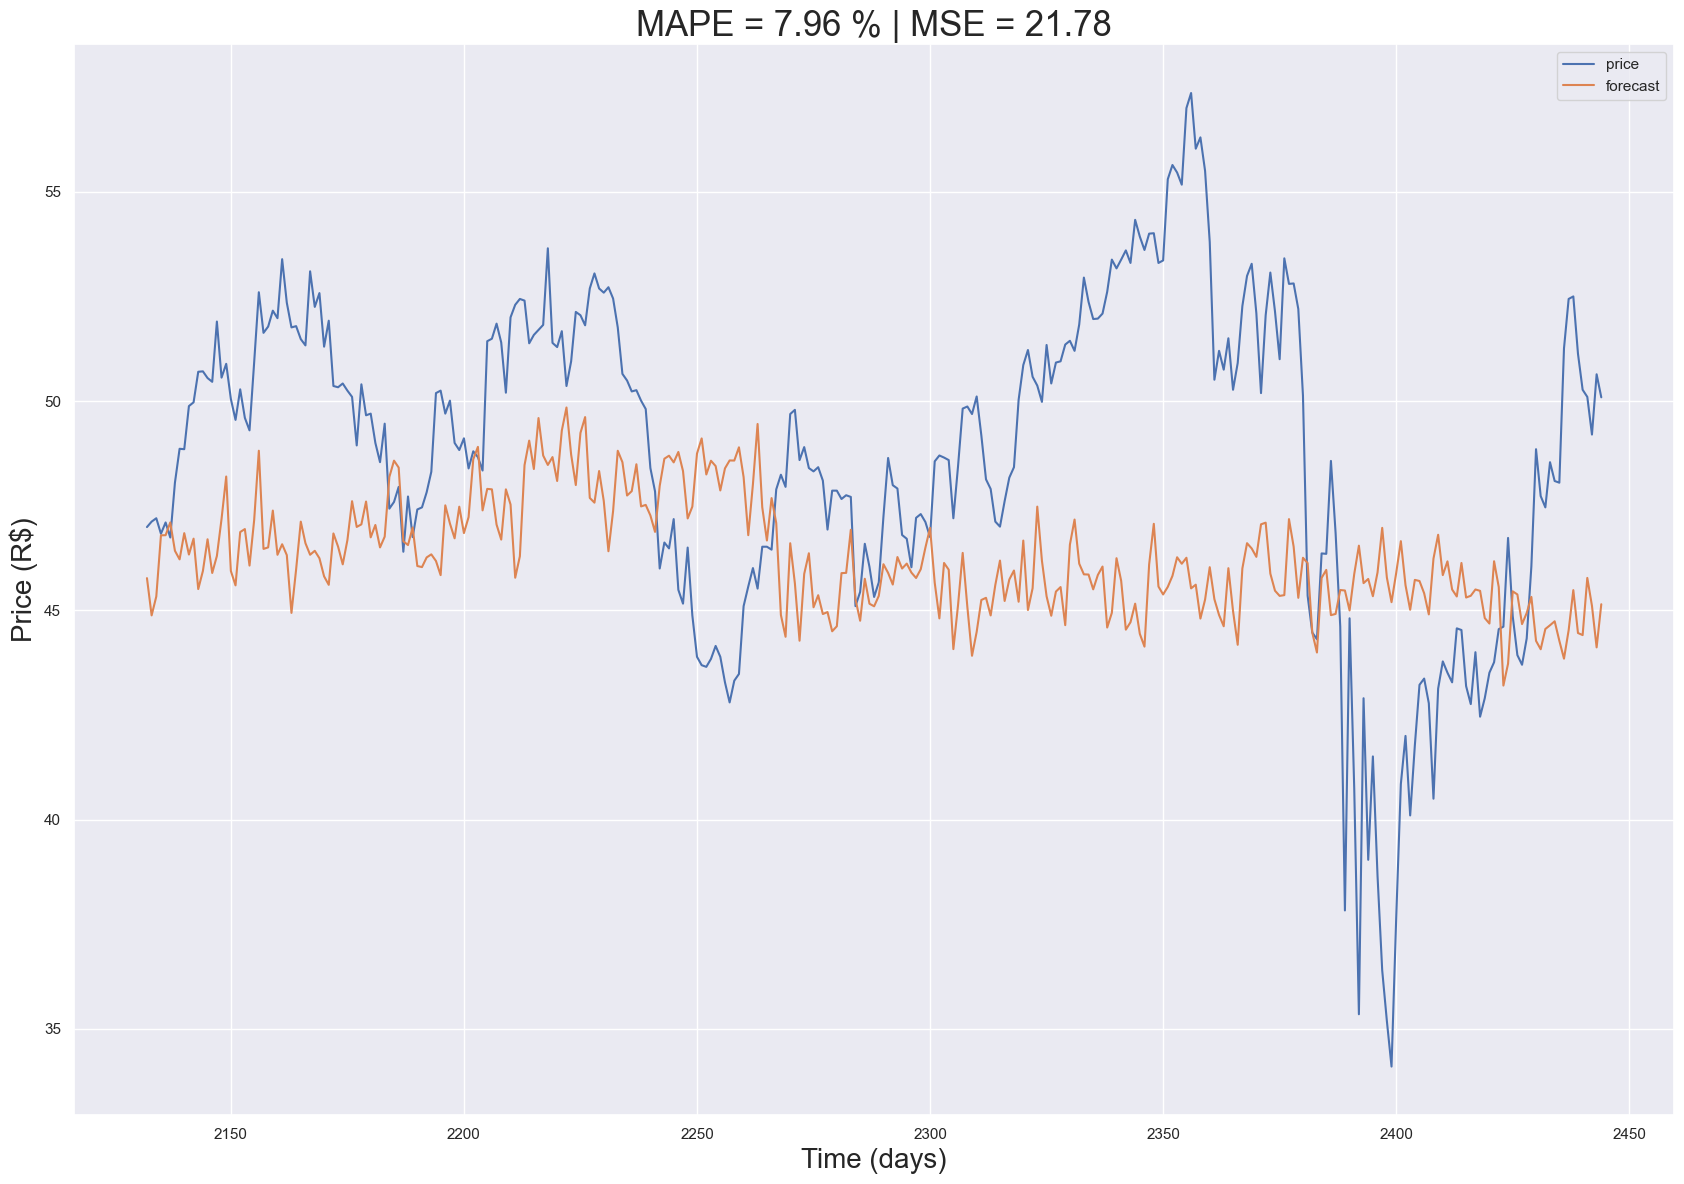

In [66]:
show_result_model(df_test=df_test, y_forecast=y_ar_forecast, model_name='ar_model', dict_results=dict_results)

#### **1.2. Autoregressive Integrated Moving Average (ARIMA) Model**
- ARIMA models provide another approach to time series forecasting. 
- Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. 
- While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

In [67]:
list_order_arima = search_best_params_arima_model(df_train=df_train, pdq=list_pdq)
print(list_order_arima)

pdq = (0, 0, 0) | AIC = 16618.5299210664
pdq = (0, 0, 1) | AIC = 13847.156698922185
pdq = (0, 0, 2) | AIC = 11721.61757042865
pdq = (0, 1, 0) | AIC = 5200.420813142258
pdq = (0, 1, 1) | AIC = 5200.445947988692
pdq = (0, 1, 2) | AIC = 5188.218276072295
pdq = (0, 2, 0) | AIC = 6614.986556130987
pdq = (0, 2, 1) | AIC = 5208.6329347461
pdq = (0, 2, 2) | AIC = 5208.589057299216
pdq = (1, 0, 0) | AIC = 5209.16410392838
pdq = (1, 0, 1) | AIC = 5209.029903912102
pdq = (1, 0, 2) | AIC = 5197.431801381949
pdq = (1, 1, 0) | AIC = 5200.762622588954
pdq = (1, 1, 1) | AIC = 5193.812436825676
pdq = (1, 1, 2) | AIC = 5189.810978508409
pdq = (1, 2, 0) | AIC = 6148.321269781811
pdq = (1, 2, 1) | AIC = 5208.913079499723
pdq = (1, 2, 2) | AIC = 5201.963443813473
pdq = (2, 0, 0) | AIC = 5209.546002363683
pdq = (2, 0, 1) | AIC = 5202.520476259298
pdq = (2, 0, 2) | AIC = 5199.147410995542
pdq = (2, 1, 0) | AIC = 5188.82969277737
pdq = (2, 1, 1) | AIC = 5190.804904831109
pdq = (2, 1, 2) | AIC = 5187.656935123

In [69]:
autoarima_model = pm.auto_arima(df_train, stepwise=True, suppress_warnings=True, error_action="ignore", information_criterion='aic', start_p=2, 
                                    start_d=1, start_q=2, lags=313, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5189.626, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5202.401, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5202.744, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5202.427, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5200.421, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5191.786, Time=0.27 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5192.782, Time=0.21 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5191.420, Time=0.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5191.381, Time=1.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5195.793, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5189.941, Time=1.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5194.800, Time=0.32 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5193.582, Time=0.94 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5187.657, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [72]:
print("ARIMA order = ", autoarima_model.order)
print("Akaike’s Information Criterion (AIC) = ", autoarima_model.aic())

ARIMA order =  (2, 1, 2)
Akaike’s Information Criterion (AIC) =  5187.656935123989


In [73]:
# model fitting
autoarima_model_fit = autoarima_model.fit(y=df_train)
autoarima_model_fit

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [74]:
# forecast with autoarima model
y_forecast = autoarima_model_fit.predict(n_periods=len(df_test[:313]))
len(y_forecast)

313

,forecast
2132,45.38
2133,45.43
2134,45.45
2135,45.47
2136,45.49
...,...
2440,45.63
2441,45.63
2442,45.63
2443,45.63


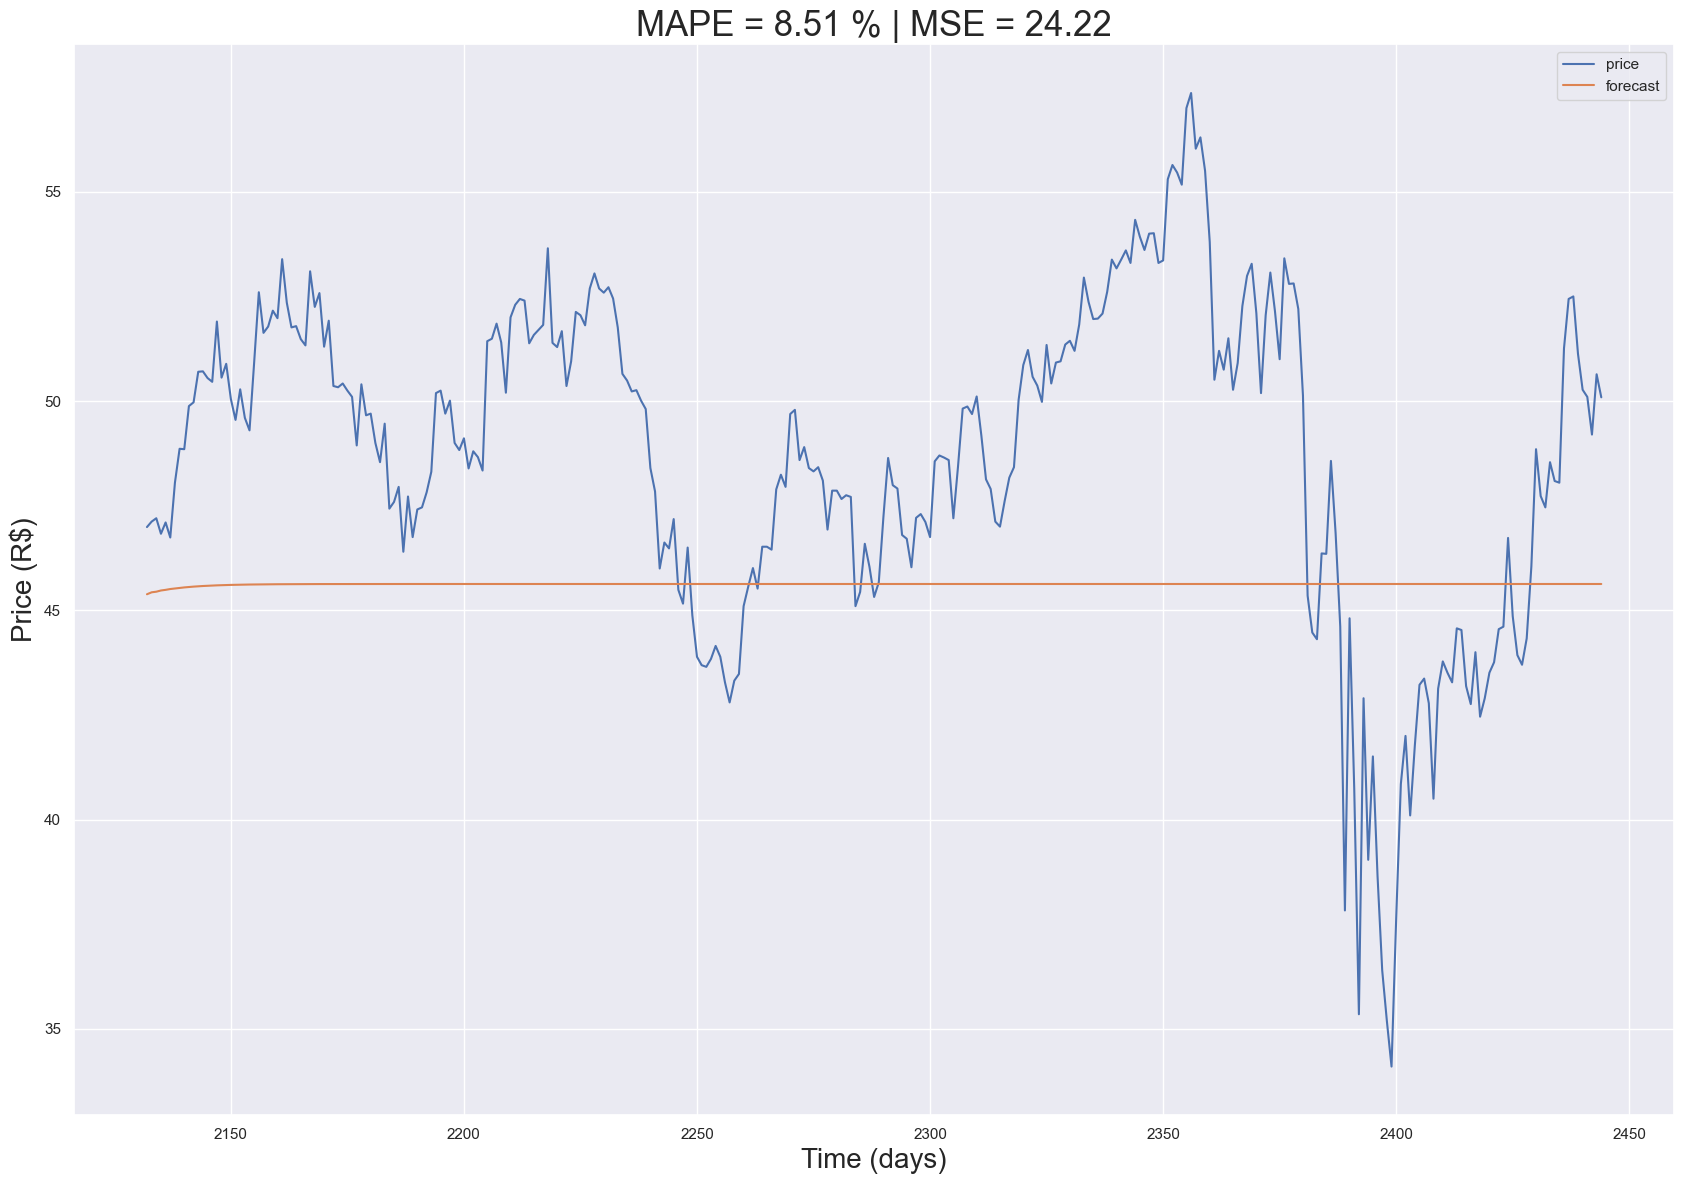

In [75]:
show_result_model(df_test=df_test, y_forecast=y_forecast, model_name='arima_model', dict_results=dict_results)

#### **1.3. Seasonal Autoregressive Integrated Moving Average (SARIMA) Model**

In [76]:
list_order_seasonal_aic = search_best_params_sarima_model(df_train=df_train, trend='t', pdq=(2, 1, 2))
print(list_order_seasonal_aic)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21483D+00    |proj g|=  2.69588D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     16      1     0     0   8.074D-03   1.215D+00
  F =   1.2147144000632459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (0, 0, 0, 12) | AIC = 5191.542201869681



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21438D+00    |proj g|=  2.94332D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     20      1     0     0   9.500D-03   1.214D+00
  F =   1.2142515441490205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (0, 0, 1, 12) | AIC = 5191.568584251423



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21378D+00    |proj g|=  3.21228D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     17      1     0     0   1.318D-02   1.214D+00
  F =   1.2136546195329716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (0, 0, 2, 12) | AIC = 5191.023297688591
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56589D+00    |proj g|=  4.32040D+05


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     46      2     0     0   3.743D+05   1.561D+00
  F =   1.5612215958399709     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (0, 1, 0, 12) | AIC = 6669.048884661636



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49609D+00    |proj g|=  8.70151D+06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     46      2     0     0   7.540D+06   1.408D+00
  F =   1.4081728185967526     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (0, 1, 1, 12) | AIC = 6018.448898496553


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36029D+00    |proj g|=  6.06637D+07



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     46      2     0     0   5.258D+07   1.809D+00
  F =   1.8091974085917146     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (0, 1, 2, 12) | AIC = 7730.417750235071
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08488D+00    |proj g|=  3.86207D+01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      2     18      1     0     0   2.750D-01   2.085D+00
  F =   2.0848759747990329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (0, 2, 0, 12) | AIC = 8901.911156543076
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92672D+00    |proj g|=  9.45914D+02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     43      2     0     0   3.113D+00   1.926D+00
  F =   1.9257349698007415     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (0, 2, 1, 12) | AIC = 8225.333911230362
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86555D+00    |proj g|=  5.06532D+04


 This problem is unconstrained.



At iterate    5    f=  1.81089D+00    |proj g|=  1.71211D+01

At iterate   10    f=  1.80969D+00    |proj g|=  2.55081D+02

At iterate   15    f=  1.79989D+00    |proj g|=  1.96343D+03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     36      1     0     0   1.974D+03   1.795D+00
  F =   1.7949670278233303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (0, 2, 2, 12) | AIC = 7669.7394066386805
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21432D+00    |proj g|=  2.67240D+02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     43      2     0     0   8.000D-03   1.214D+00
  F =   1.2142192168977399     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (1, 0, 0, 12) | AIC = 5191.4307408519635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21529D+00    |proj g|=  9.51053D+02


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     43      2     0     0   2.848D-02   1.214D+00
  F =   1.2143618069451645     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (1, 0, 1, 12) | AIC = 5194.038744814181
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21430D+00    |proj g|=  6.20437D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     15      1     0     0   1.856D-02   1.214D+00
  F =   1.2138371926751825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (1, 0, 2, 12) | AIC = 5193.801789566978
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43854D+00    |proj g|=  4.31510D+05


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     46      2     0     0   3.738D+05   1.434D+00
  F =   1.4335968248874451     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (1, 1, 0, 12) | AIC = 6126.856861320066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46630D+00    |proj g|=  6.87278D+06


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     46      2     0     0   5.955D+06   1.396D+00
  F =   1.3962272914672329     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (1, 1, 1, 12) | AIC = 5969.513170816281


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55953D+00    |proj g|=  1.43134D+07



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     46      2     0     0   1.241D+07   1.449D+00
  F =   1.4486455278336479     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (1, 1, 2, 12) | AIC = 6195.024530682675


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87054D+00    |proj g|=  4.59069D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      2     15      1     0     0   2.187D-01   1.870D+00
  F =   1.8704901872381827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (1, 2, 0, 12) | AIC = 7989.7701583836115
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75336D+00    |proj g|=  4.23899D+03


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     43      2     0     0   3.451D-01   1.749D+00
  F =   1.7487250822840736     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (1, 2, 1, 12) | AIC = 7472.56375085929
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90906D+00    |proj g|=  5.50383D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     17      1     0     0   3.706D+00   1.908D+00
  F =   1.9084404570243858     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


pdq = (2, 1, 2) | param_seasonal = (1, 2, 2, 12) | AIC = 8155.5901087519815


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21365D+00    |proj g|=  2.62160D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     43      2     0     0   7.851D-03   1.214D+00
  F =   1.2135733165509577     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (2, 0, 0, 12) | AIC = 5190.676621773284


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21477D+00    |proj g|=  8.47446D+02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     14      1     0     0   2.537D-02   1.214D+00
  F =   1.2140210608396877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (2, 0, 1, 12) | AIC = 5194.585803420428
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21423D+00    |proj g|=  5.97814D+02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      2     20      1     0     0   1.788D-02   1.214D+00
  F =   1.2137991882728907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (2, 0, 2, 12) | AIC = 5195.639738795606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39939D+00    |proj g|=  4.29858D+05


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     46      2     0     0   3.725D+05   1.395D+00
  F =   1.3949069675178987     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (2, 1, 0, 12) | AIC = 5963.88330949632


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44378D+00    |proj g|=  5.52793D+06



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     46      2     0     0   4.790D+06   1.387D+00
  F =   1.3872681521583330     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


pdq = (2, 1, 2) | param_seasonal = (2, 1, 1, 12) | AIC = 5933.311400803132
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57757D+00    |proj g|=  1.54559D+07


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      2     46      2     0     0   1.340D+07   1.458D+00
  F =   1.4582230621351702     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (2, 1, 2, 12) | AIC = 6237.863136944366


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80505D+00    |proj g|=  4.82354D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      2     21      1     0     0   2.858D-01   1.805D+00
  F =   1.8049894811304061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (2, 2, 0, 12) | AIC = 7712.475147540052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74831D+00    |proj g|=  8.21896D+02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      2     18      1     0     0   6.139D-01   1.747D+00
  F =   1.7473955286543523     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
pdq = (2, 1, 2) | param_seasonal = (2, 2, 1, 12) | AIC = 7468.894534182158
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82453D+00    |proj g|=  1.12003D+03


 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      2     43      2     0     0   4.385D+00   1.823D+00
  F =   1.8232464980764276     

ABNORMAL_TERMINATION_IN_LNSRCH                              
pdq = (2, 1, 2) | param_seasonal = (2, 2, 2, 12) | AIC = 7794.323067797887


Best SARIMA: (2, 1, 2)x(2, 2, 2, 12)12 | AIC:5190.676621773284
[(2, 0, 0, 12), 5190.676621773284]


In [77]:
list_order_seasonal_aic

[(2, 0, 0, 12), 5190.676621773284]

In [78]:
sarima_model = SARIMAX(df_train, order=(2, 1, 2), seasonal_order=list_order_seasonal_aic[0], trend='c', 
                       enforce_stationarity=False, enforce_invertibility=False)

In [79]:
# fit
sarima_fit = sarima_model.fit()
print(sarima_fit)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19948D+00    |proj g|=  2.42592D-02


 This problem is unconstrained.



At iterate    5    f=  1.19945D+00    |proj g|=  4.39851D-04

At iterate   10    f=  1.19944D+00    |proj g|=  2.59867D-03

At iterate   15    f=  1.19943D+00    |proj g|=  8.45640D-05

At iterate   20    f=  1.19943D+00    |proj g|=  5.13451D-04

At iterate   25    f=  1.19943D+00    |proj g|=  2.07484D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     26     29      1     0     0   6.401D-05   1.199D+00
  F =   1.1994297064714363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [80]:
# forecast
y_forecast_sarima = sarima_fit.predict(start=df_test.index[0], end=df_test.index[-1]).to_numpy()
len(y_forecast_sarima)

313

,forecast
2132,45.41
2133,45.43
2134,45.38
2135,45.40
2136,45.29
...,...
2440,45.80
2441,45.80
2442,45.80
2443,45.80


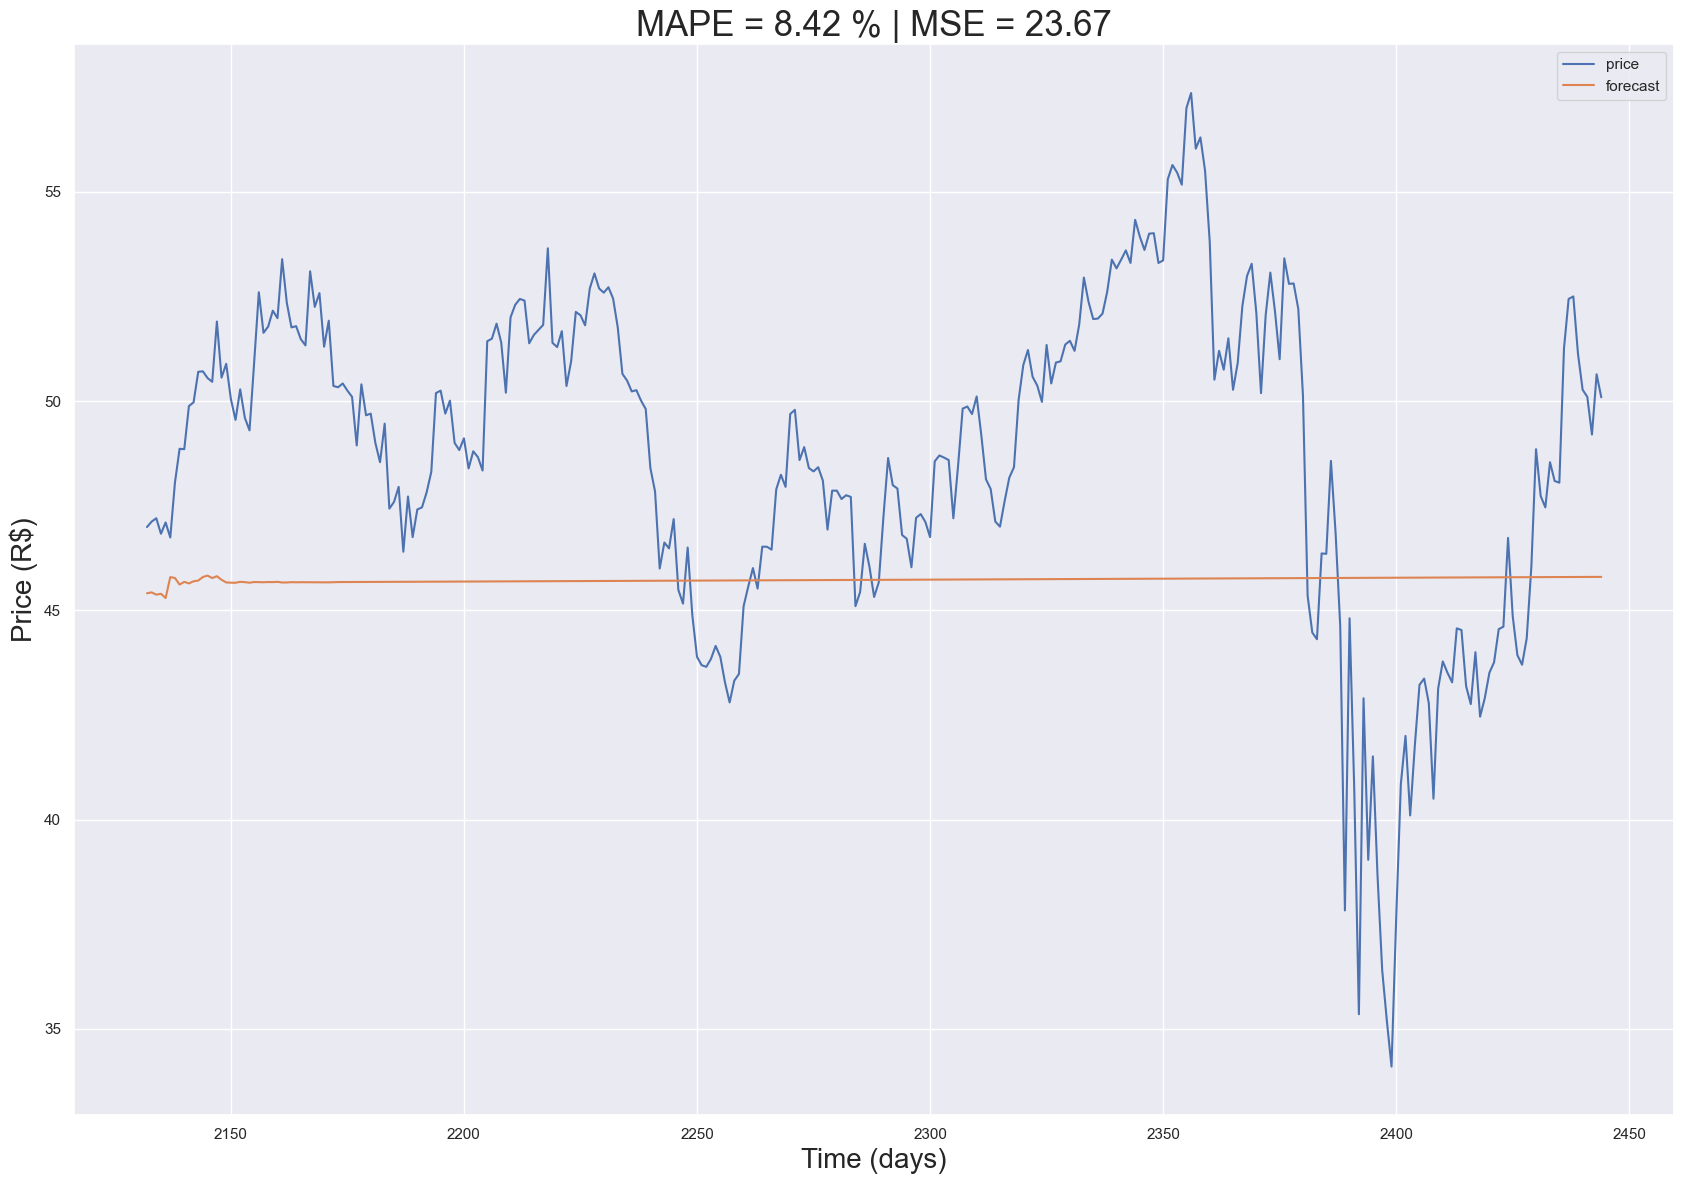

In [81]:
show_result_model(df_test=df_test, y_forecast=y_forecast_sarima, model_name='sarima_model', dict_results=dict_results)

#### **2. Result**

In [83]:
dict_results

{'ar_model': [7.95581387216246, 21.780365011672703],
 'arima_model': [8.514601465338373, 24.220627458539646],
 'sarima_model': [8.42368376250149, 23.667332999485144]}

---

## **3. Machine Learning Models**

#### Models Used
- Random Forest
- SVM

### a. Split Data

In [84]:
size_train = 2132
size_test = 313
print(size_train)
print(size_test)

df_train = df_vale3.iloc[:size_train]
df_test = df_vale3.iloc[size_train:]
print(df_train.columns)
print(df_test.columns)

2132
313
Index(['price', 'residuals', 'trend', 'seasonality', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')
Index(['price', 'residuals', 'trend', 'seasonality', 'diff_1', 'diff_2',
       'diff_3', 'diff_4', 'diff_5'],
      dtype='object')


In [86]:
df_vale3_without_target = df_train.columns
df_vale3_without_target = df_vale3_without_target.drop('price')

print(df_vale3_without_target)

Index(['residuals', 'trend', 'seasonality', 'diff_1', 'diff_2', 'diff_3',
       'diff_4', 'diff_5'],
      dtype='object')


Text(0.5, 1.0, 'Train size: 2132')

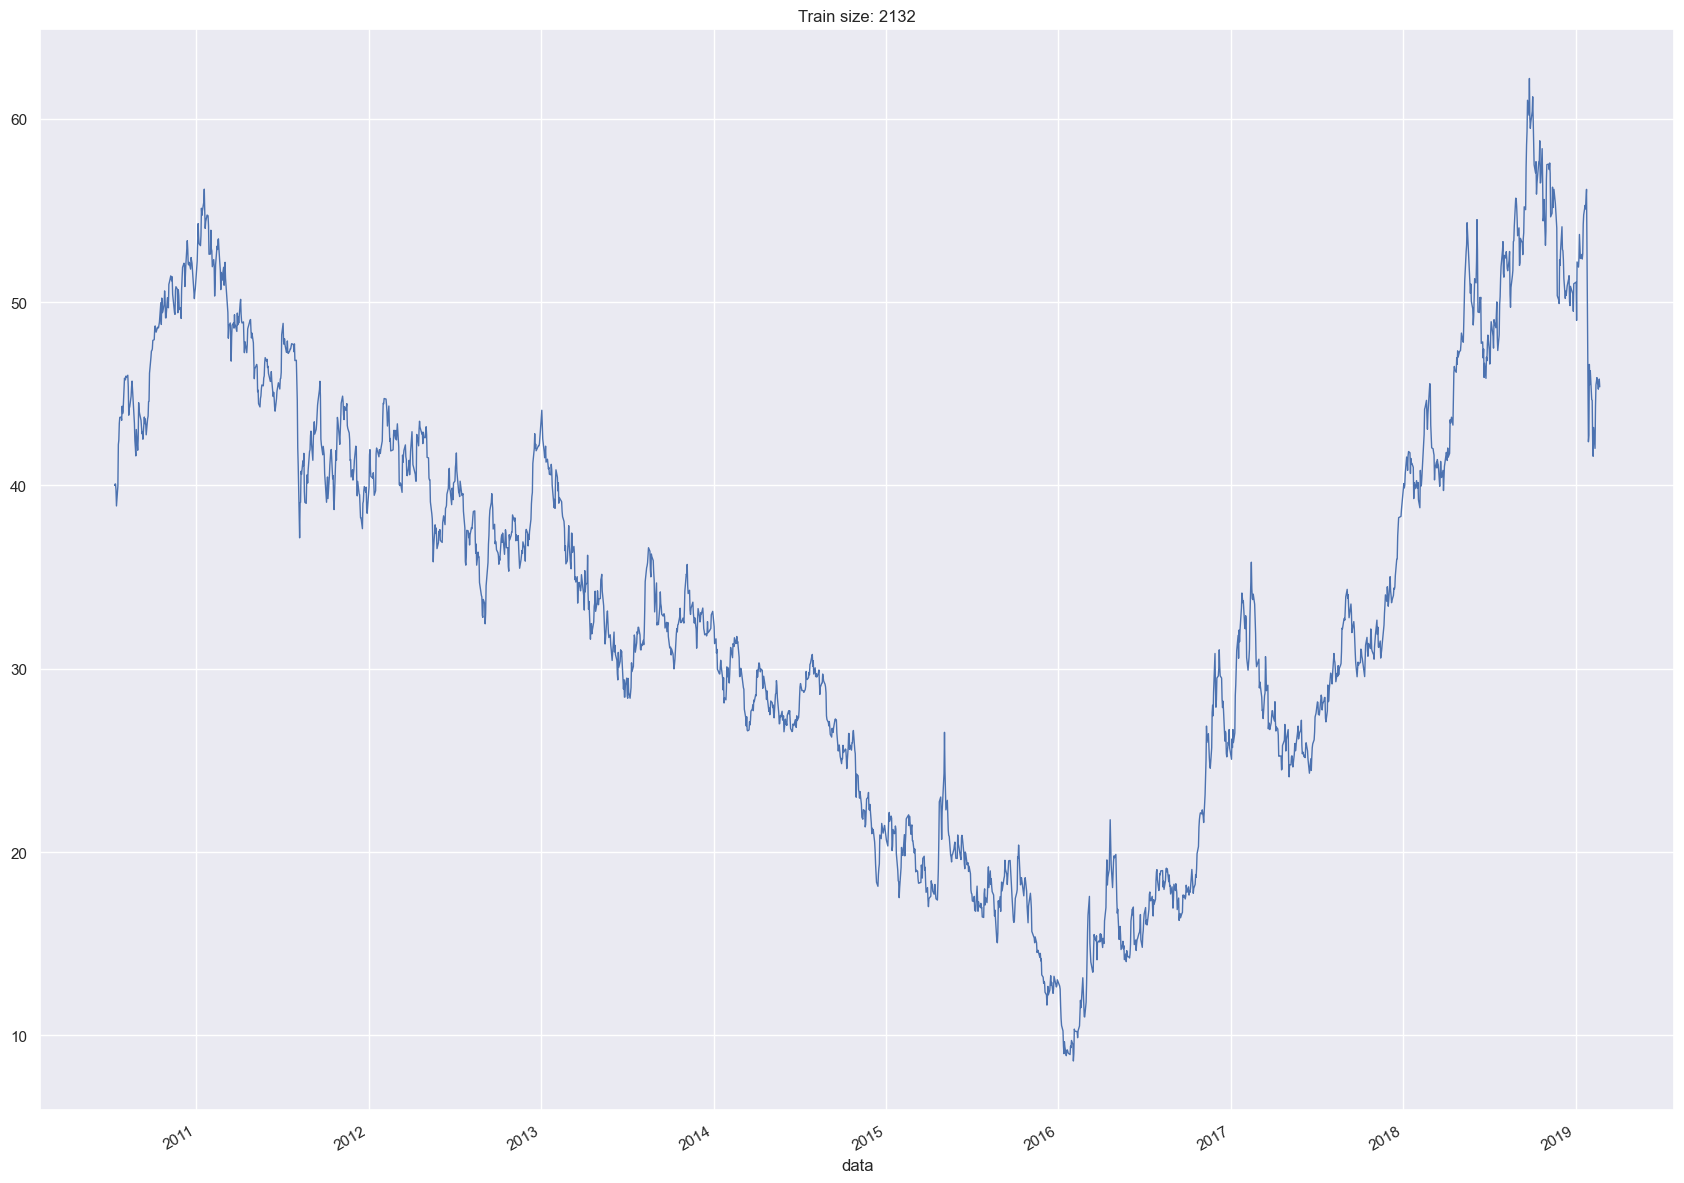

In [87]:
df_train['price'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Train size: {len(df_train)}')

Text(0.5, 1.0, 'Test size: 313')

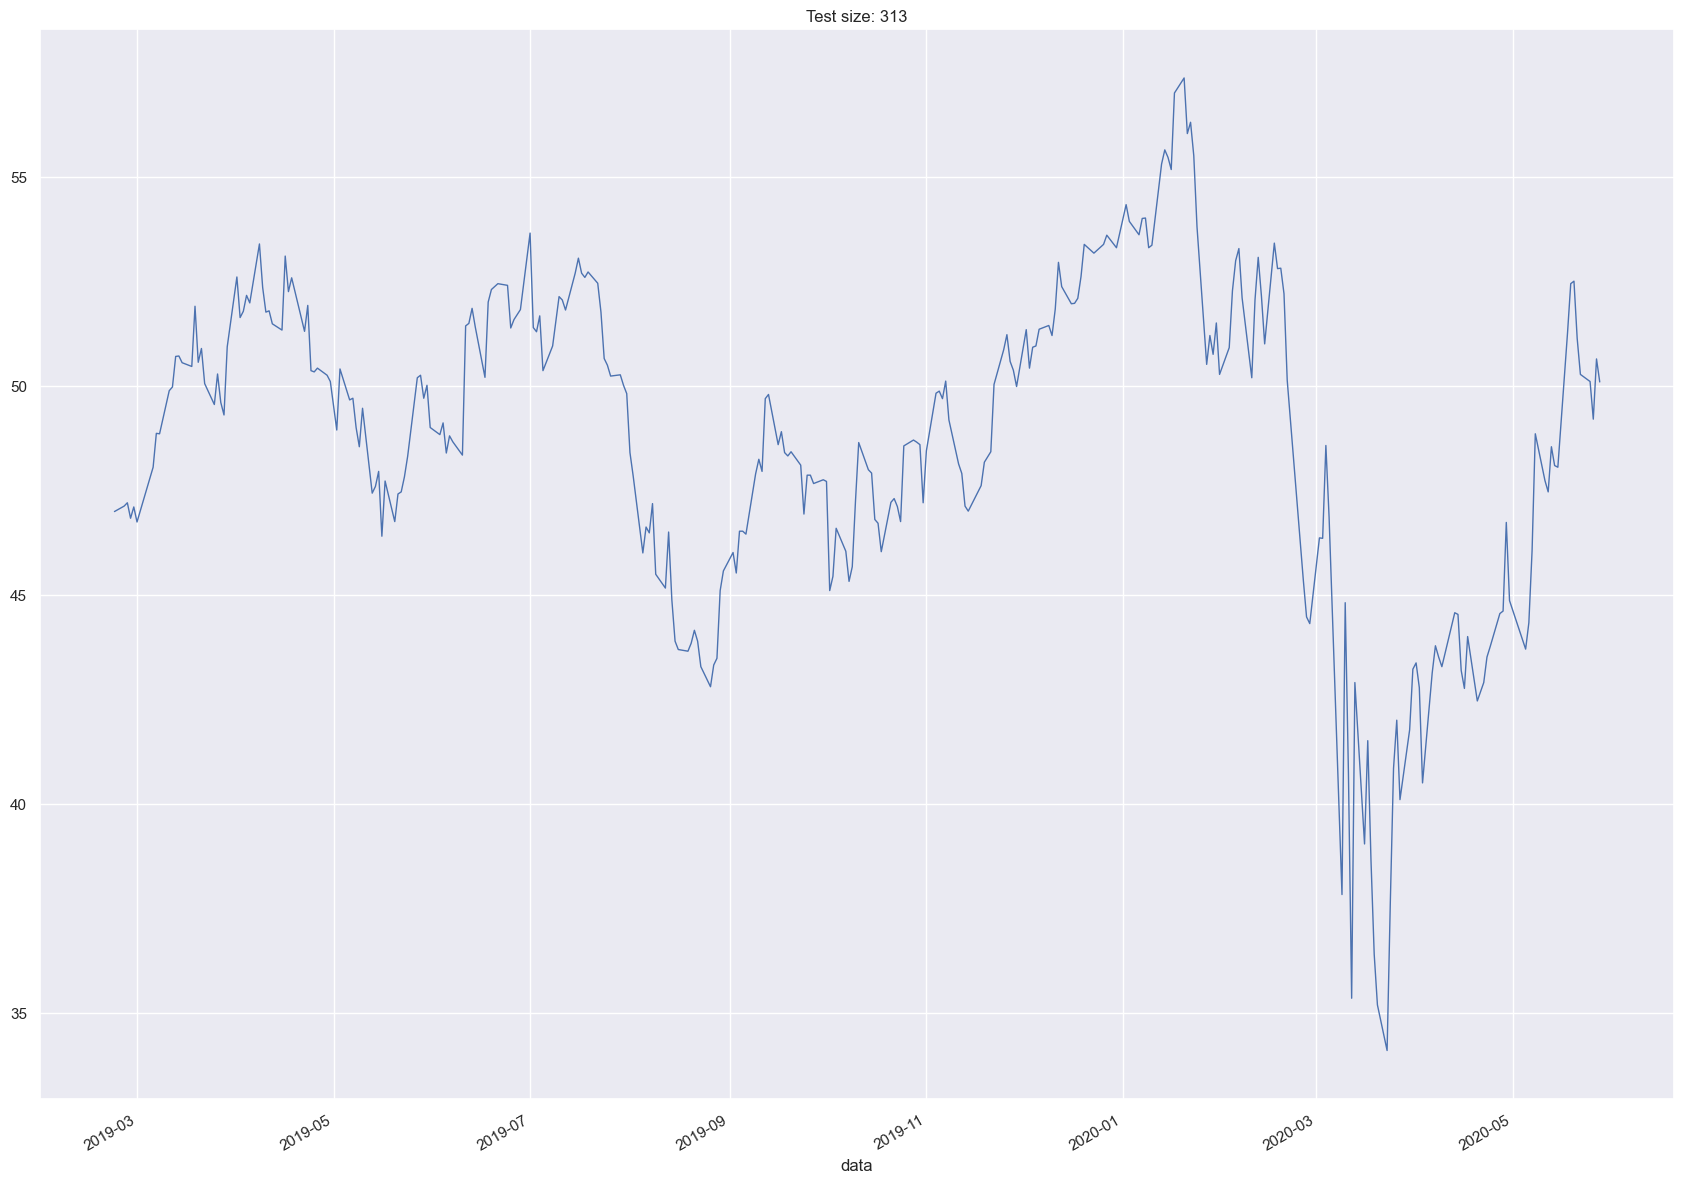

In [89]:
df_test['price'].plot(linewidth=1)
plt.grid(True)
plt.title(f'Test size: {len(df_test)}')

In [90]:
print("Index of train", df_train.index)
print("-------------------------------------------------------------------------------------------------------------------")
print("Index of test", df_test.index)

Index of train DatetimeIndex(['2010-07-12', '2010-07-13', '2010-07-14', '2010-07-15',
               '2010-07-16', '2010-07-19', '2010-07-20', '2010-07-21',
               '2010-07-22', '2010-07-23',
               ...
               '2019-02-08', '2019-02-11', '2019-02-12', '2019-02-13',
               '2019-02-14', '2019-02-15', '2019-02-18', '2019-02-19',
               '2019-02-20', '2019-02-21'],
              dtype='datetime64[ns]', name='data', length=2132, freq=None)
-------------------------------------------------------------------------------------------------------------------
Index of test DatetimeIndex(['2019-02-22', '2019-02-25', '2019-02-26', '2019-02-27',
               '2019-02-28', '2019-03-01', '2019-03-06', '2019-03-07',
               '2019-03-08', '2019-03-11',
               ...
               '2020-05-15', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-25', '2020-05-26',
               '2020-05-27', '2020-05-28'],


In [91]:
X_train = df_train[df_vale3_without_target]
y_train = df_train['price']
print(len(X_train))
print(len(y_train))
print(type(X_train))
print(type(y_train))
print((X_train[:5]))
print(y_train[:5])


X_train = df_train[df_vale3_without_target]
y_train = df_train['price']

2132
2132
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
            residuals  trend  seasonality  diff_1  diff_2  diff_3  diff_4  \
data                                                                        
2010-07-12       1.00  41.83         1.00   -0.60   -0.46    0.49    0.98   
2010-07-13       1.04  41.91         1.00    0.07   -0.53   -0.39    0.56   
2010-07-14       1.03  41.98         1.00    0.01    0.08   -0.52   -0.38   
2010-07-15       1.04  42.05         1.00   -0.32   -0.31   -0.24   -0.84   
2010-07-16       1.03  42.12         1.00   -0.88   -1.20   -1.19   -1.12   

            diff_5  
data                
2010-07-12    0.42  
2010-07-13    1.05  
2010-07-14    0.57  
2010-07-15   -0.70  
2010-07-16   -1.72  
data
2010-07-12   40.00
2010-07-13   40.07
2010-07-14   40.08
2010-07-15   39.76
2010-07-16   38.88
Name: price, dtype: float64


In [92]:
X_test = df_test[df_vale3_without_target]
y_test = df_test['price']
print(len(X_test))
print(len(y_test))
print(type(X_test))
print(type(y_test))
print(X_test[:5])
print(y_test[:5])

313
313
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
            residuals  trend  seasonality  diff_1  diff_2  diff_3  diff_4  \
data                                                                        
2019-02-22       0.96  46.70         1.00    1.61    1.19    1.50    1.74   
2019-02-25       0.93  46.89         1.00    0.13    1.74    1.32    1.63   
2019-02-26       0.94  47.09         1.00    0.08    0.21    1.82    1.40   
2019-02-27       0.89  47.32         1.00   -0.37   -0.29   -0.16    1.45   
2019-02-28       0.88  47.58         1.00    0.27   -0.10   -0.02    0.11   

            diff_5  
data                
2019-02-22    1.11  
2019-02-25    1.87  
2019-02-26    1.71  
2019-02-27    1.03  
2019-02-28    1.72  
data
2019-02-22   46.99
2019-02-25   47.12
2019-02-26   47.20
2019-02-27   46.83
2019-02-28   47.10
Name: price, dtype: float64


### **b. Evaluation and Modeling**

In [93]:
dict_results = {}

### **Model Building**

### **i. Random Forest**

**Why Random Forest:**
- Feature Importance
- Non-linearity and Complex Relationships
- Robustness to Outliers and Noise
- Handles High-dimensional Data
- No Assumption of Linearity
- Flexibility in Model Tuning

**Considerations**:
- **Sequential Nature of Time Series**: Random Forests do not inherently account for the sequential nature of time series data. Feature engineering (e.g., lagged variables) is crucial to capture temporal dependencies.

- **Interpretability**: While Random Forests provide feature importance metrics, interpreting the results in the context of time series forecasting may require additional domain knowledge.

In [95]:
# RandomForest params dict
rf_params_one = {}
rf_params_one['criterion'] = 'absolute_error'
rf_params_one['n_estimators'] = 10
rf_params_one['max_depth'] = 10
rf_params_one['max_features'] = None
rf_params_one['max_leaf_nodes'] = 30
rf_params_one['min_samples_leaf'] = 1
rf_params_one['random_state'] = 0
rf_params_one['n_jobs'] = -1

In [100]:
from sklearn.ensemble import RandomForestRegressor
model_rf_regressor = RandomForestRegressor(**rf_params_one)
model_rf_regressor

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features=None, max_leaf_nodes=30, n_estimators=10,
                      n_jobs=-1, random_state=0)

In [101]:
model_rf_regressor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features=None, max_leaf_nodes=30, n_estimators=10,
                      n_jobs=-1, random_state=0)

In [102]:
y_pred_rf_regressor = model_rf_regressor.predict(X_test)
y_pred_rf_regressor[:5]

array([46.5835, 47.382 , 47.614 , 47.7015, 47.9175])

In [104]:
print("Length of y_train = ", len(y_train))
print("Length of y_test = ", len(y_test))

Length of y_train =  2132
Length of y_test =  313


,forecast
data,
2019-02-22,46.58
2019-02-25,47.38
2019-02-26,47.61
2019-02-27,47.70
2019-02-28,47.92
...,...
2020-05-22,52.30
2020-05-25,50.49
2020-05-26,50.60


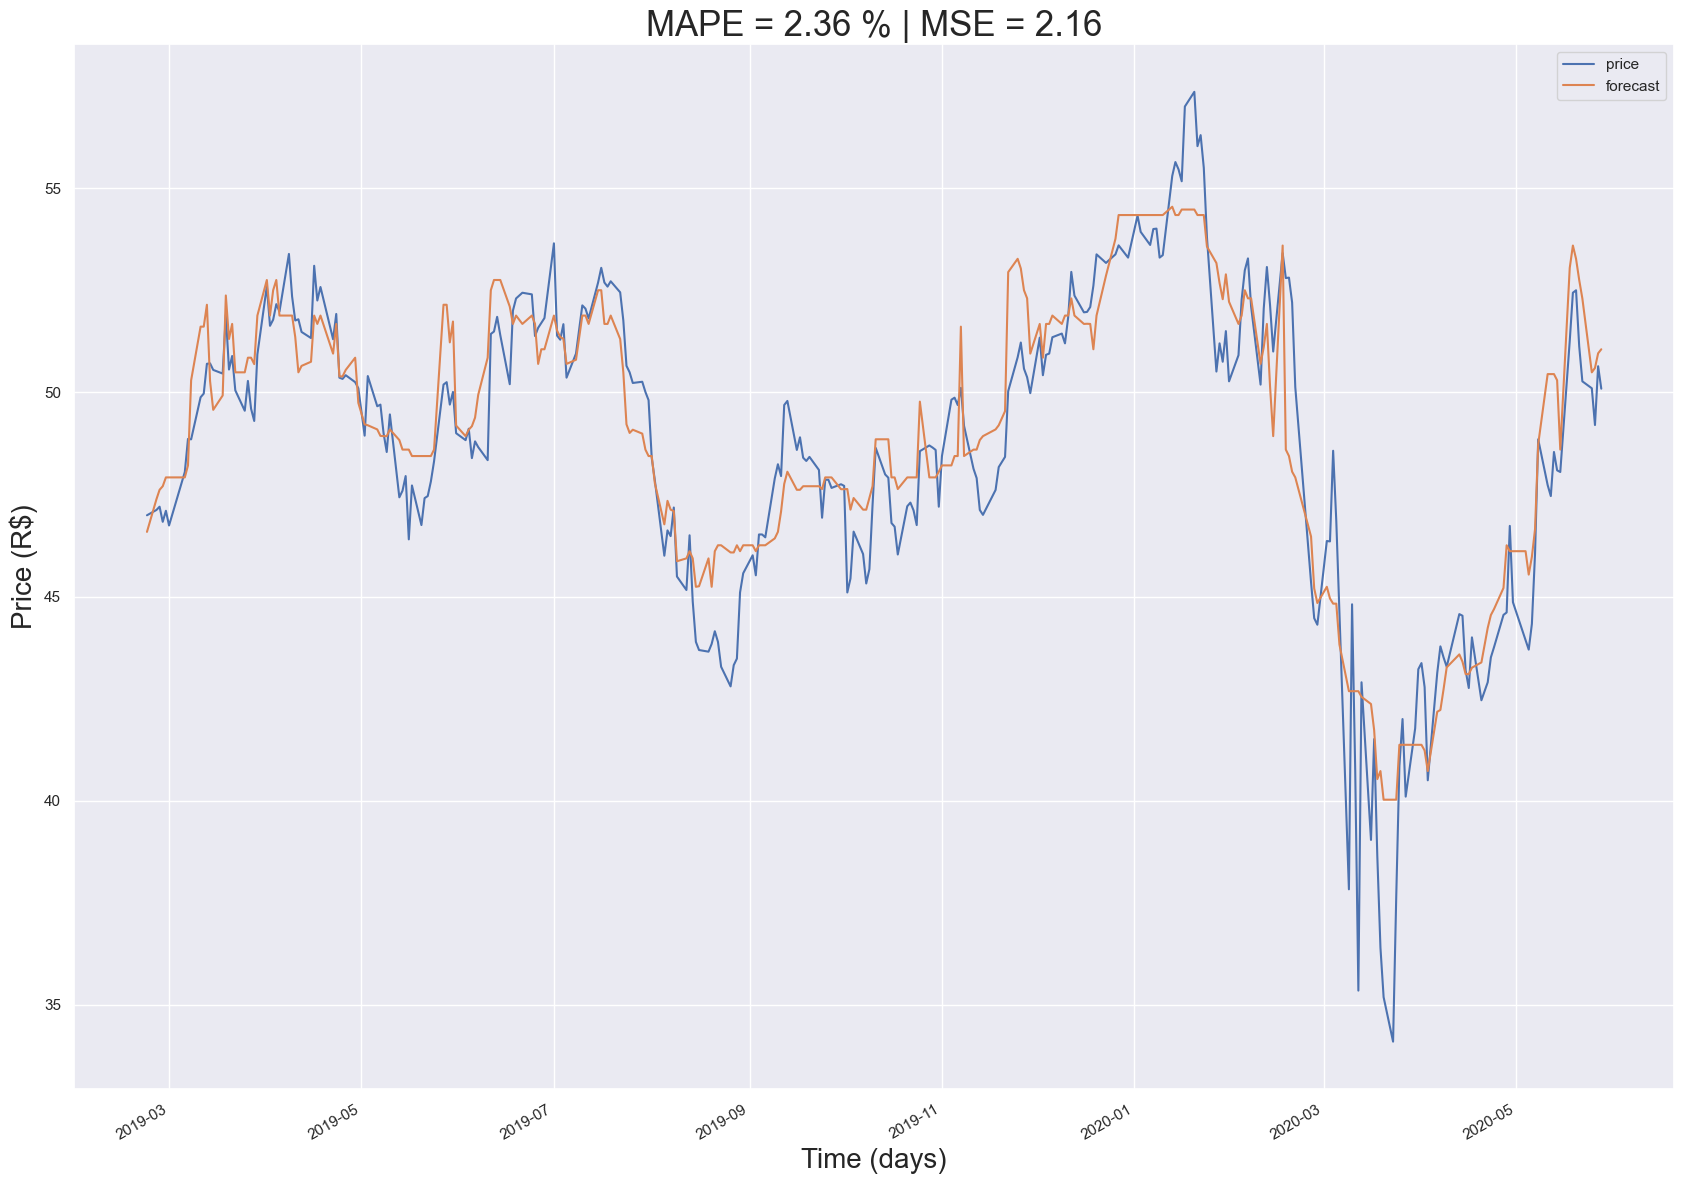

In [105]:
show_result_model(df_test=y_test, y_forecast=y_pred_rf_regressor, model_name='model_rf_regressor', dict_results=dict_results)

### **ii. Support Vector Machine (SVM)**

**Why SVM:**
- Non-linearity and Complex Patterns
- Effective in High-dimensional Spaces
- Robustness to Overfitting and Outliers
- Kernel Flexibility
- Interpretability

**Considerations**:
- **Feature Engineering**: Effective feature engineering is crucial for SVMs in time series forecasting. This includes selecting appropriate lagged variables, transforming data to achieve stationarity, and handling missing values.

- **Computational Complexity**: SVMs can be computationally expensive, especially with large datasets. Parameter tuning (C, gamma for RBF kernel) and cross-validation are essential to optimize performance.
---

Gamma == learning rate

In [109]:
from sklearn.svm import SVR
model_svm_regressor = SVR(kernel='rbf', gamma= 0.1)
model_svm_regressor

SVR(gamma=0.1)

In [110]:
model_svm_regressor.fit(X_train, y_train)

SVR(gamma=0.1)

In [111]:
y_pred_svm_regressor = model_svm_regressor.predict(X_test)
y_pred_svm_regressor[:5]

array([45.99098843, 47.55474102, 47.58538796, 47.07265872, 47.54542208])

,forecast
data,
2019-02-22,45.99
2019-02-25,47.55
2019-02-26,47.59
2019-02-27,47.07
2019-02-28,47.55
...,...
2020-05-22,43.17
2020-05-25,49.22
2020-05-26,48.83


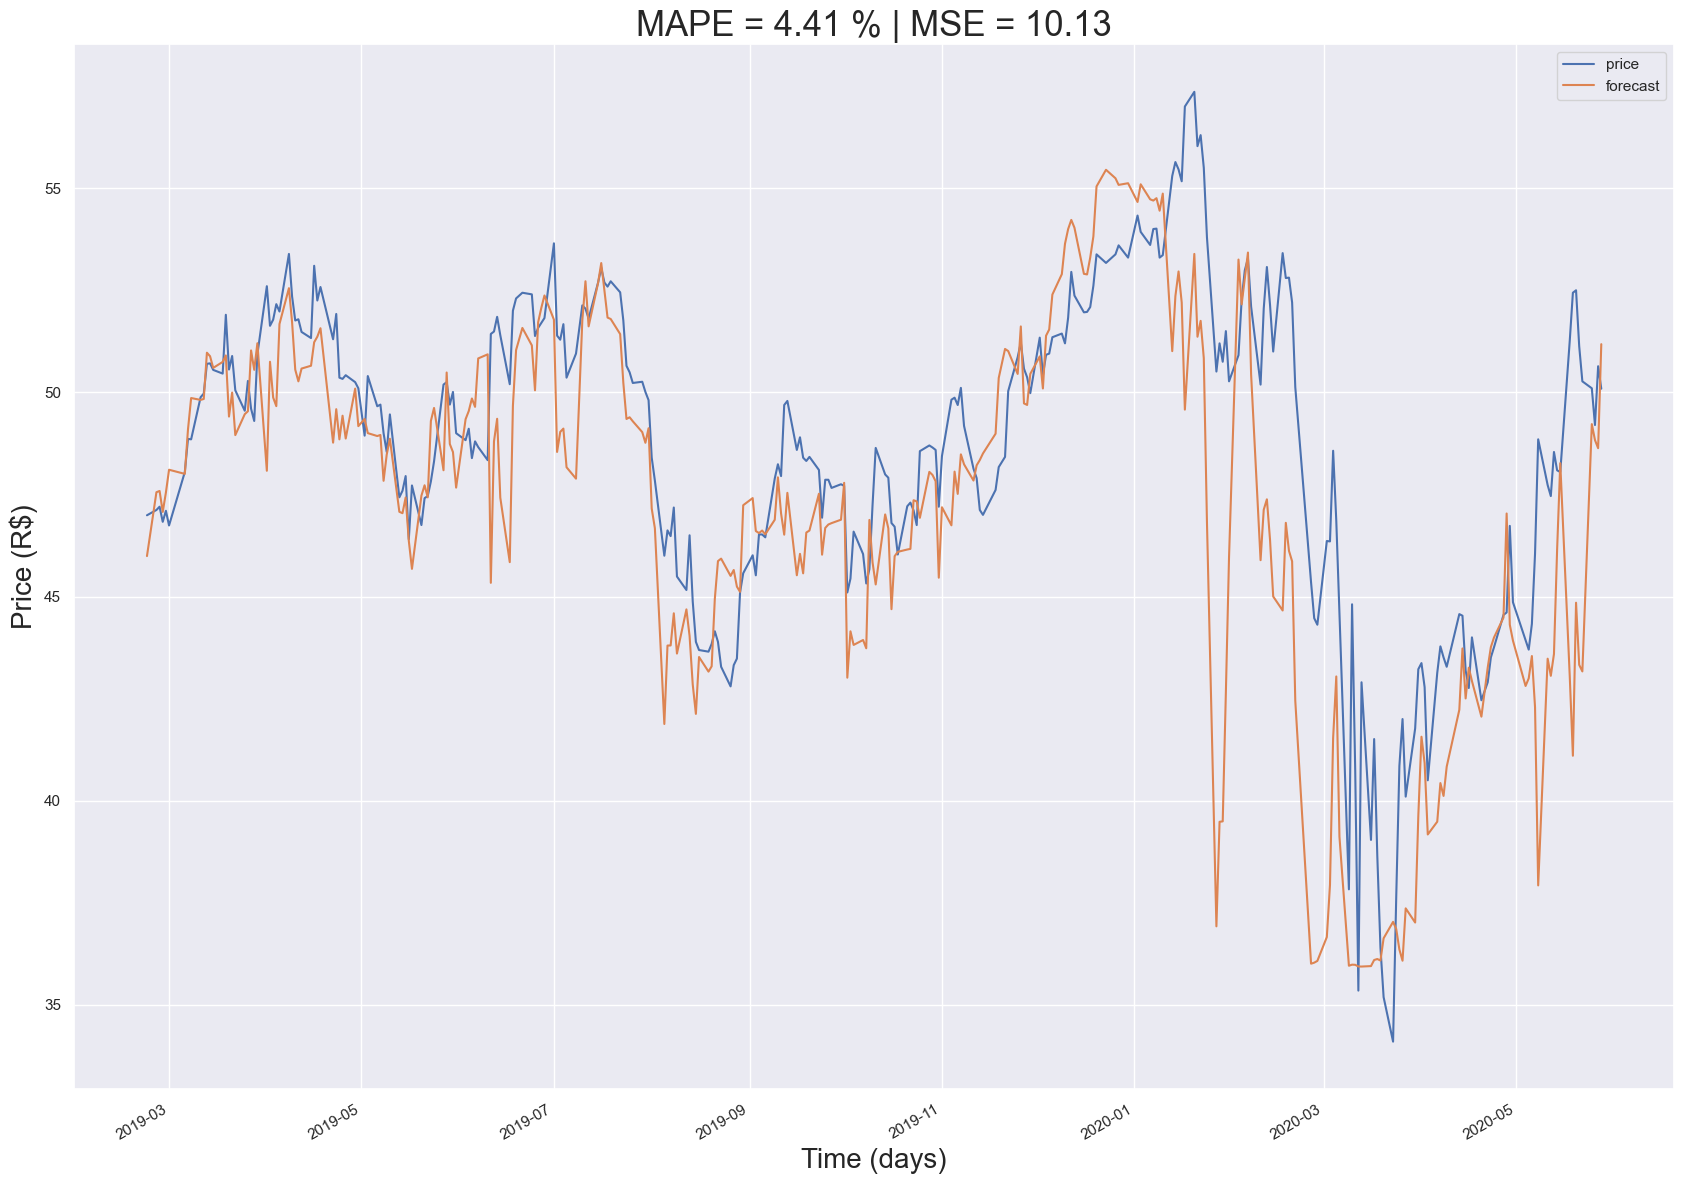

In [112]:
show_result_model(df_test=y_test, y_forecast=y_pred_svm_regressor, model_name='model_svm_regressor', dict_results=dict_results)

### **iii. Results**

In [113]:
dict_results

{'model_rf_regressor': [2.362809020091369, 2.1579547476038337],
 'model_svm_regressor': [4.4083922049644535, 10.128901656346505]}